Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## Imports

### Dataset

In [1]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re


In [2]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

movies_w_mentions = pd.read_csv('../data/movies_with_mentions.csv')

Loaded 10006 train conversations
Loaded 1342 test conversations


In [3]:
train_data[119]

{'movieMentions': {'119144': 'Wonder Woman  (2017)',
  '138962': 'Bad Moms (2016)',
  '93013': "Daddy's Home  (2015)",
  '184098': 'Guardians of the Galaxy  (2014)'},
 'respondentQuestions': {'119144': {'suggested': 1, 'seen': 1, 'liked': 1},
  '138962': {'suggested': 0, 'seen': 1, 'liked': 0},
  '93013': {'suggested': 0, 'seen': 1, 'liked': 1},
  '184098': {'suggested': 0, 'seen': 0, 'liked': 1}},
 'messages': [{'timeOffset': 0,
   'text': 'Hello',
   'senderWorkerId': 31,
   'messageId': 3210},
  {'timeOffset': 1, 'text': 'Hello!', 'senderWorkerId': 30, 'messageId': 3211},
  {'timeOffset': 8,
   'text': 'How is your day going?',
   'senderWorkerId': 30,
   'messageId': 3212},
  {'timeOffset': 16,
   'text': 'I love movies, have you seen @119144',
   'senderWorkerId': 31,
   'messageId': 3213},
  {'timeOffset': 19,
   'text': 'Can you recommend any good comedy movies?',
   'senderWorkerId': 30,
   'messageId': 3214},
  {'timeOffset': 21,
   'text': 'I am doing good how about u',
   's

In [4]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [5]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "User 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "User 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
User 1: Hi can you help me find a musical
User 2: hey what kind of movies interest you
User 2: yes i would love to!
User 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
User 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
User 2: I like Hairspray  (2007) too!
User 2: oops, I meant Chicago  (2002)
User 1: Yeah I have seen Chicago  (2002) many times
User 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
User 1: I have not seen Mamma Mia!  (2008) I think I may like that one
User 2: The music is all from ABBA and it is so good
User 2: I hope you will enjoy it as much as I do
User 1: That is great that group does have some good music thanks for the help. Bye
User 2: no problem bye


In [6]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


## Tratamento e Limpeza dos datasets

In [7]:
def clean_data(dataset):
    """
    Remove diálogos inválidas do dataset 
    """

    invalid_indexes = []

    # Identifica diálogos inválidas
    for i, conv in enumerate(dataset):
        if (
            isinstance(conv.get("movieMentions"), list) # Se for lista em vez de dicionário
            or not isinstance(conv.get("movieMentions", {}), dict) # Se dicionário for inválido
            or "messages" not in conv # Diálogo sem mensagem
            or not conv["messages"] # Diálogo sem mensagem
        ):
            invalid_indexes.append(i)

    # Remove invalidos
    for i in sorted(invalid_indexes, reverse=True):
        del dataset[i]

    print(f"✅ Conversas válidas restantes: {len(dataset)}")
    print(f"🗑️ Conversas removidas: {len(invalid_indexes)}")

clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 1
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


In [8]:
import re
import copy
import math
import numpy as np
import pandas as pd
from collections import defaultdict

# -----------------------------
# 0) Helpers: parsing & normalize
# -----------------------------

_YEAR_RE = re.compile(r"\((\d{4})\)\s*$")

def has_year(title: str) -> bool:
    if not isinstance(title, str):
        return False
    return _YEAR_RE.search(title.strip()) is not None

def extract_year(title: str):
    if not isinstance(title, str):
        return None
    m = _YEAR_RE.search(title.strip())
    return int(m.group(1)) if m else None

def base_title(title: str) -> str:
    """
    Remove trailing '(YYYY)' and normalize spaces.
    Example:
      'American Pie  (1999)' -> 'American Pie'
      'American Pie ' -> 'American Pie'
    """
    if not isinstance(title, str):
        return ""
    t = title.strip()
    t = re.sub(r"\(\d{4}\)\s*$", "", t).strip()
    t = re.sub(r"\s+", " ", t).strip()
    return t

def norm_title(title: str) -> str:
    """Lower + remove extra whitespace (keeps punctuation)."""
    return base_title(title).lower().strip()

def safe_get_flags(conv, key):
    data = conv.get(key, {})
    return {} if isinstance(data, list) else data

# -----------------------------
# 1) Build candidate index from movies_w_mentions
# -----------------------------

def build_candidates_index(movies_w_mentions: pd.DataFrame):
    """
    Expects columns: movieId, movieName, nbMentions
    Returns:
      - base_norm -> list[{id, name, year, nb}]
      - id -> {name, year, nb, base_norm}
    """
    idx = defaultdict(list)
    by_id = {}

    required = {"movieId", "movieName"}
    missing = required - set(movies_w_mentions.columns)
    if missing:
        raise ValueError(f"movies_w_mentions is missing columns: {missing}")

    # nbMentions optional (fallback to 0)
    for _, row in movies_w_mentions.iterrows():
        mid = str(row["movieId"])
        name = row["movieName"]
        nb = int(row["nbMentions"]) if "nbMentions" in movies_w_mentions.columns and pd.notna(row["nbMentions"]) else 0

        y = extract_year(name)
        bnorm = norm_title(name)

        rec = {"id": mid, "name": name, "year": y, "nb": nb, "base_norm": bnorm}
        by_id[mid] = rec

        # Only index candidates that HAVE YEAR (you requested "substituir por filmes com data")
        if y is not None:
            idx[bnorm].append(rec)

    return idx, by_id

# -----------------------------
# 2) Scoring rule you asked for:
#    - if multiple candidates:
#        center_year = median(years of other movies w/ year in the conversation)
#        pick argmin |year-center| - 0.5*log1p(nbMentions)
#    - if no center_year: pick max nbMentions
# -----------------------------

def choose_candidate(candidates, center_year):
    """
    candidates: list of recs with year != None
    center_year: int or None
    """
    if not candidates:
        return None

    if center_year is None:
        # pick most mentioned
        return max(candidates, key=lambda r: (r["nb"], r["year"] if r["year"] is not None else -1))

    def score(r):
        # abs distance - 0.5*log1p(nbMentions)
        return abs(r["year"] - center_year) - 0.5 * math.log1p(max(r["nb"], 0))

    # minimize score, tie-break by higher nbMentions
    return min(candidates, key=lambda r: (score(r), -r["nb"]))

# -----------------------------
# 3) Merge flags safely when old_id -> new_id
#    (Optional but recommended to avoid losing labels)
# -----------------------------

def merge_question_flags(old_flags: dict, new_flags: dict):
    """
    Both dicts can have keys: suggested, seen, liked
    We'll keep "stronger" signal:
      liked order: 1 (positive) > 0 (negative) > 2/None (unknown)
      seen  order: 1 (seen)     > 0 (not seen) > 2/None (unknown)
      suggested: max
    """
    def pick(order, a, b):
        # order: list of preferred values
        for v in order:
            if a == v or b == v:
                return v
        # fallback: keep b if exists else a
        return b if b is not None else a

    out = {}
    old_flags = old_flags or {}
    new_flags = new_flags or {}

    out["suggested"] = max(old_flags.get("suggested", 0), new_flags.get("suggested", 0))

    out["liked"] = pick([1, 0, 2], old_flags.get("liked", None), new_flags.get("liked", None))
    out["seen"]  = pick([1, 0, 2], old_flags.get("seen", None),  new_flags.get("seen", None))

    # keep any extra fields if exist
    for k, v in old_flags.items():
        if k not in out:
            out[k] = v
    for k, v in new_flags.items():
        if k not in out:
            out[k] = v

    return out

# -----------------------------
# 4) Apply replacement inside ONE conversation
# -----------------------------

def get_center_year_from_conv(conv, exclude_ids=None):
    """
    Median year of OTHER movies in movieMentions that have year in the title.
    exclude_ids: set of ids (strings) to ignore when computing center.
    """
    exclude_ids = exclude_ids or set()
    mentions = conv.get("movieMentions", {}) or {}
    years = []
    for mid, title in mentions.items():
        mid = str(mid)
        if mid in exclude_ids:
            continue
        y = extract_year(title)
        if y is not None:
            years.append(y)
    return int(np.median(years)) if years else None

def apply_replacement_in_conv(conv, old_id: str, new_rec: dict):
    """
    Mutates conv in-place:
      - movieMentions: replace key old_id -> new_id (and set title to candidate name)
      - initiatorQuestions/respondentQuestions: move/merge flags
      - messages: replace '@old_id' -> '@new_id'
    """
    new_id = str(new_rec["id"])
    new_name = new_rec["name"]

    # 1) movieMentions
    mentions = conv.get("movieMentions", {})
    if isinstance(mentions, dict):
        # remove old, add/overwrite new
        if old_id in mentions:
            mentions.pop(old_id, None)
        # Ensure new appears with name WITH YEAR
        mentions[new_id] = new_name
        conv["movieMentions"] = mentions

    # 2) Questions flags: initiatorQuestions, respondentQuestions
    for key in ("initiatorQuestions", "respondentQuestions"):
        q = safe_get_flags(conv, key)
        if not q:
            # if list or empty, just skip
            continue
        old_flags = q.get(old_id)
        new_flags = q.get(new_id)
        if old_flags is not None or new_flags is not None:
            merged = merge_question_flags(old_flags or {}, new_flags or {})
            q[new_id] = merged
            q.pop(old_id, None)
            conv[key] = q

    # 3) Messages: replace @old_id with @new_id
    msgs = conv.get("messages", [])
    if isinstance(msgs, list):
        old_tag = f"@{old_id}"
        new_tag = f"@{new_id}"
        for m in msgs:
            txt = m.get("text")
            if isinstance(txt, str) and old_tag in txt:
                m["text"] = txt.replace(old_tag, new_tag)
        conv["messages"] = msgs

    return conv

# -----------------------------
# 5) Main: fix_missing_years_in_dataset (NO mutation of original)
# -----------------------------

def fix_missing_years_in_dataset(
    dataset,
    movies_w_mentions: pd.DataFrame,
    verbose=True,
    max_log_examples=10
):
    """
    Returns:
      fixed_dataset, report

    Rules:
      - if missing-year title has no substitute: skip
      - if exactly 1 substitute: replace
      - if multiple substitutes:
          center_year = median(years of other movies with year in THIS conversation)
          if center_year exists: choose min |year-center| - 0.5*log1p(nbMentions)
          else: choose max nbMentions
    """
    cand_idx, by_id = build_candidates_index(movies_w_mentions)
    fixed = copy.deepcopy(dataset)

    report = {
        "total_convs": len(dataset),
        "missing_year_items": 0,
        "replaced": 0,
        "skipped_no_candidate": 0,
        "skipped_bad_mentions": 0,
        "multi_candidate": 0,
        "examples": {
            "skipped_no_candidate": [],
            "multi_candidate_choices": [],
            "replaced": [],
        }
    }

    for conv in fixed:
        mentions = conv.get("movieMentions", {})
        if not isinstance(mentions, dict) or not mentions:
            report["skipped_bad_mentions"] += 1
            continue

        # find ids with missing year in their movieMentions title
        missing_ids = []
        for mid, title in mentions.items():
            mid = str(mid)
            if isinstance(title, str) and not has_year(title):
                missing_ids.append(mid)

        if not missing_ids:
            continue

        # process each missing id (one by one)
        for old_id in missing_ids:
            old_title = mentions.get(old_id)
            if not isinstance(old_title, str):
                continue

            report["missing_year_items"] += 1

            bnorm = norm_title(old_title)
            candidates = cand_idx.get(bnorm, [])

            if not candidates:
                report["skipped_no_candidate"] += 1
                if len(report["examples"]["skipped_no_candidate"]) < max_log_examples:
                    report["examples"]["skipped_no_candidate"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title
                    })
                continue

            # compute center_year excluding this missing movie id
            center_year = get_center_year_from_conv(conv, exclude_ids={old_id})

            chosen = None
            if len(candidates) == 1:
                chosen = candidates[0]
            else:
                report["multi_candidate"] += 1
                chosen = choose_candidate(candidates, center_year)

                if len(report["examples"]["multi_candidate_choices"]) < max_log_examples:
                    report["examples"]["multi_candidate_choices"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title,
                        "center_year": center_year,
                        "candidates": [(c["id"], c["name"], c["year"], c["nb"]) for c in candidates],
                        "chosen": (chosen["id"], chosen["name"], chosen["year"], chosen["nb"]) if chosen else None
                    })

            if chosen is None:
                report["skipped_no_candidate"] += 1
                continue

            # If chosen id equals old id, nothing to do (rare)
            if str(chosen["id"]) == str(old_id):
                continue

            # Apply replacement in conv
            apply_replacement_in_conv(conv, str(old_id), chosen)
            report["replaced"] += 1

            if len(report["examples"]["replaced"]) < max_log_examples:
                report["examples"]["replaced"].append({
                    "conversationId": conv.get("conversationId"),
                    "old_id": old_id,
                    "old_title": old_title,
                    "new_id": str(chosen["id"]),
                    "new_title": chosen["name"],
                    "center_year": center_year
                })

            # update mentions ref (since we mutated it)
            mentions = conv.get("movieMentions", {})

    if verbose:
        print("=" * 70)
        print("✅ fix_missing_years_in_dataset — Report")
        print("=" * 70)
        print(f"Convs:                 {report['total_convs']}")
        print(f"Missing-year items:     {report['missing_year_items']}")
        print(f"Replaced:               {report['replaced']}")
        print(f"Multi-candidate cases:  {report['multi_candidate']}")
        print(f"Skipped (no candidate): {report['skipped_no_candidate']}")
        print(f"Skipped (bad mentions): {report['skipped_bad_mentions']}")
        print("=" * 70)

    return fixed, report

# -----------------------------
# 6) Convenience: show which ones were skipped
# -----------------------------

def show_skipped_cases(report, n=10):
    print("\n--- Skipped: no candidate ---")
    for ex in report["examples"]["skipped_no_candidate"][:n]:
        print(ex)

    print("\n--- Multi-candidate choices ---")
    for ex in report["examples"]["multi_candidate_choices"][:n]:
        print(ex)

    print("\n--- Replaced examples ---")
    for ex in report["examples"]["replaced"][:n]:
        print(ex)

# -----------------------------
# 7) USAGE EXAMPLE
# -----------------------------
# movies_w_mentions_df = pd.read_csv("movies_w_mentions.csv")  # you already have it
# fixed_test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions_df, verbose=True)
# show_skipped_cases(fix_report, n=10)




test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions, verbose=True)
show_skipped_cases(fix_report, n=10)

✅ fix_missing_years_in_dataset — Report
Convs:                 1342
Missing-year items:     322
Replaced:               72
Multi-candidate cases:  7
Skipped (no candidate): 250
Skipped (bad mentions): 0

--- Skipped: no candidate ---
{'conversationId': '20041', 'old_id': '175203', 'old_title': 'Hot Tub Time Machine'}
{'conversationId': '20058', 'old_id': '183056', 'old_title': 'The Big Lebowski'}
{'conversationId': '20059', 'old_id': '183056', 'old_title': 'The Big Lebowski'}
{'conversationId': '20115', 'old_id': '177915', 'old_title': 'Uncle Buck'}
{'conversationId': '20133', 'old_id': '112346', 'old_title': 'The Fifth Element'}
{'conversationId': '20195', 'old_id': '177915', 'old_title': 'Uncle Buck'}
{'conversationId': '20378', 'old_id': '166069', 'old_title': 'Kill Bill'}
{'conversationId': '20381', 'old_id': '177915', 'old_title': 'Uncle Buck'}
{'conversationId': '20387', 'old_id': '177915', 'old_title': 'Uncle Buck'}
{'conversationId': '20454', 'old_id': '108934', 'old_title': 'T

## Extração de itens e Montagem Matriz Usuário-Item (Offline)

### DF offline

In [52]:



def extract_interactions_crag_compliant(conv):
    """
    1. Usa movieMentions (Robustez de extração).
    2. MAS filtra explícitos 'liked=0' (Protocolo CRAG: remove negativos).
    3. Define User = ConversationId (Protocolo CRAG: Pseudo-user).
    """
    rows = []
    
    # OPÇÃO A: Protocolo CRAG estrito (Pseudo-User) 
    # user_id = conv.get("conversationId") 
    
    # OPÇÃO B: Sua abordagem (User real - Geralmente melhor performance)
    user_id = conv.get("initiatorWorkerId")
    
    # O "ouro" da extração textual
    mentions = conv.get("movieMentions", {})
    
    # O "ouro" do sentimento (para filtrar negativos)
    # Precisamos checar tanto o initiator quanto o respondent para saber o sentimento
    init_q = conv.get("initiatorQuestions", {})
    resp_q = conv.get("respondentQuestions", {})
    
    # Helper para checar sentimento
    def is_explicitly_liked(mid_str):
        # Verifica Iniciador (Seeker)
        if mid_str in init_q:
            # Só aceita se liked == 1. Se for 0 ou None, retorna False.
            if init_q[mid_str].get('liked') == 1: 
                return True
            
        # Verifica Respondente (Recommender)
        if mid_str in resp_q:
            if resp_q[mid_str].get('liked') == 1: 
                return True
            
        return False

    if user_id and isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # CRAG: "exclude these items [negatively mentioned]" 
                if is_explicitly_liked(movie_id_str):
                    rows.append((user_id, int(movie_id_str), 1))
                
            except ValueError:
                continue
                
    return rows


def build_redial_interaction_df_robust(dataset):
    all_rows = []
    for conv in dataset:
        all_rows.extend(extract_interactions_crag_compliant(conv))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa, conta como 1)
    df = df.drop_duplicates()
    return df

# --- RE-GERAR DATAFRAMES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_redial_interaction_df_robust(train_data)
df_test = build_redial_interaction_df_robust(test_data)



print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)




Extraindo dados com metodologia Robusta (Menções)...
   userId  movieId  rating
0       2   196336       1
1       2   204322       1
2       2   114851       1
3       2   128905       1
4       2   143189       1
(34752, 3)
   userId  movieId  rating
0     956   111776       1
1     956   151656       1
2     956   134643       1
3     956    94688       1
4     959   125431       1
(4461, 3)


#### Filtrar por interações



In [53]:
movie_counts = df_train['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 1].index.tolist()
df_train = df_train[df_train['movieId'].isin(popular_movies)]
df_test  = df_test[df_test['movieId'].isin(popular_movies)]

print(df_train.head())
print(df_train.shape)

print(df_test.head(7))
print(df_test.shape)


test_data[0]

   userId  movieId  rating
0       2   196336       1
1       2   204322       1
2       2   114851       1
3       2   128905       1
4       2   143189       1
(34752, 3)
   userId  movieId  rating
0     956   111776       1
1     956   151656       1
2     956   134643       1
3     956    94688       1
4     959   125431       1
6     959   132562       1
7     959    77161       1
(3995, 3)


{'movieMentions': {'111776': 'Super Troopers (2001)',
  '91481': 'Beverly Hills Cop (1984)',
  '151656': 'Police Academy  (1984)',
  '134643': 'American Pie  (1999)',
  '124771': '48 Hrs. (1982)',
  '94688': 'Police Academy 2: Their First Assignment (1985)',
  '101794': 'Lethal Weapon (1987)'},
 'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1},
  '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
  '151656': {'suggested': 1, 'seen': 0, 'liked': 1},
  '134643': {'suggested': 0, 'liked': 1, 'seen': 1},
  '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
  '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
  '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi I am looking for a movie like @111776',
   'senderWorkerId': 956,
   'messageId': 204171},
  {'timeOffset': 48,
   'text': 'You should watch @151656',
   'senderWorkerId': 957,
   'messageId': 204172},
  {'timeOffset': 90,
   'text': 'Is that a great one? I have n

### Matrix Factorization

In [54]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix



def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """
        Cria matriz esparsa a partir de DataFrame
        user_mapper e movie_mapper são dicionarios do mapeamento
    """

    df_mapped = df.copy()

    # Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
    
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix



In [65]:
#Utility matrix (user-item)

np.random.seed(42)

#all_data = pd.concat([df_train, df_test]) # Concatena train + test para garantir que todos os IDs estejam mapeados


user_ids = sorted(df_train['userId'].unique())
movie_ids = sorted(df_test['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_user_item_sparse = create_sparse_matrix(df_train, user_mapper, movie_mapper, (n_users, n_movies))
test_user_item_sparse = create_sparse_matrix(df_test, user_mapper, movie_mapper, (n_users, n_movies))


train_item_user_sparse = train_user_item_sparse.T.tocsr()
test_item_user_sparse  = test_user_item_sparse.T.tocsr()








In [66]:
nonzero_cols = train_user_item_sparse[:10].nonzero()[1]
unique_cols = np.unique(nonzero_cols)

# pegar apenas os 6 primeiros filmes relevantes
selected_cols = unique_cols[:6]

# recorte da matriz
small_matrix = train_user_item_sparse[:10, selected_cols].toarray()

df_view = pd.DataFrame(
    small_matrix,
    columns=[f"Movie_{c}" for c in selected_cols],
    index=[f"User_{i}" for i in range(10)]
)

print(df_view)




        Movie_2  Movie_4  Movie_16  Movie_19  Movie_20  Movie_21
User_0      0.0      1.0       0.0       1.0       0.0       1.0
User_1      0.0      1.0       0.0       0.0       0.0       0.0
User_2      0.0      0.0       0.0       0.0       0.0       0.0
User_3      1.0      0.0       1.0       0.0       1.0       0.0
User_4      1.0      1.0       0.0       0.0       0.0       1.0
User_5      0.0      0.0       0.0       0.0       0.0       0.0
User_6      0.0      0.0       0.0       0.0       0.0       0.0
User_7      0.0      1.0       0.0       0.0       0.0       0.0
User_8      0.0      0.0       0.0       0.0       0.0       0.0
User_9      0.0      0.0       0.0       0.0       0.0       0.0


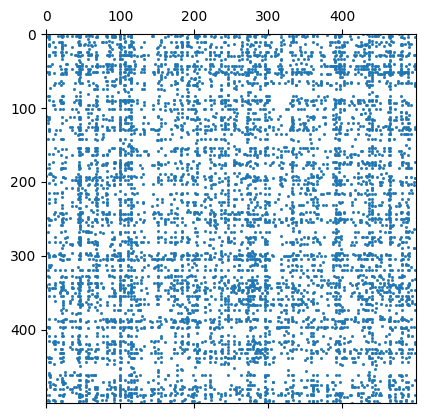

In [67]:
import matplotlib.pyplot as plt
plt.spy(train_user_item_sparse[:500, :500], markersize=1)
plt.show()


In [69]:
import numpy as np

def matrix_stats(M):


    print(f"Dimensões (usuários x itens): {M.shape}")
    print(f"Número total de elementos: {M.shape[0] * M.shape[1]:,}")
    
    # Elementos não nulos
    nnz = M.nnz

    # Densidade / Sparsidade
    density = nnz / (M.shape[0] * M.shape[1])
    print(f"Densidade: {density:.6f}")
    print(f"Esparsidade: {1 - density:.6f}")


    print(f"Média dos ratings: {M.data.mean():.2f}")


# Chamada:
matrix_stats(train_user_item_sparse)


Dimensões (usuários x itens): (659, 1450)
Número total de elementos: 955,550
Densidade: 0.024340
Esparsidade: 0.975660
Média dos ratings: 1.00


In [70]:

import pickle

with open("./variables/train_user_item_sparse.pkl", "wb") as f:
    pickle.dump(train_user_item_sparse, f)

with open("./variables/test_user_item_sparse.pkl", "wb") as f:
    pickle.dump(test_user_item_sparse, f)

In [71]:
with open("./variables/train_user_item_sparse.pkl", "rb") as f:
    train_user_item_sparse = pickle.load(f)

with open("./variables/test_user_item_sparse.pkl", "rb") as f:
    test_user_item_sparse = pickle.load(f)
    

## Extração de Itens (LLM)

### Chave API Open AI

In [16]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI
from dotenv import load_dotenv
import os


In [17]:
#Chave API
load_dotenv() 
API_KEY = os.getenv("API_KEY")

client = OpenAI(api_key=API_KEY)
async_client = AsyncOpenAI(api_key=API_KEY)

In [18]:

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233

A vida é feita de altos e baixos, cabe a nós aproveitar os momentos bons e aprender com os ruins.


### Dataset: Ids -> Filmes

In [19]:

# Troca ids por nome dos filmes

import copy

def id_to_title(dataset):
  
    dataset_titled = copy.deepcopy(dataset)

    # Acessando conversa dentro das mensagens
    for conv in dataset_titled:
        message = conv.get("messages", {}) 
        mentions = conv.get("movieMentions", {})
        
        # Acessando texto dentro da conversa 
        for text in message:
            utt = text.get("text", {})
            #print(text)
            
            # Itera filmes mencionados
            for id, title in mentions.items(): # Mapeando id nome
                tag = f"@{id}"
                if tag in utt:
                    utt = utt.replace(tag,title) # Trocando id por filme
                    #print(utt_new)
                    
                    
            # Trocando o texto
            text["text"] = utt

                
    return dataset_titled

    
train_data_titled = id_to_title(train_data)   
test_data_titled = id_to_title(test_data)   


test_data_titled[42]



{'movieMentions': {'119144': 'Wonder Woman  (2017)',
  '77610': 'Sky High  (2003)',
  '133236': 'X-Men: Apocalypse (2016)',
  '177915': 'Uncle Buck',
  '134885': 'The Hunger Games  (2012)',
  '100750': 'The Hunger Games: Catching Fire (2013)',
  '181715': 'Logan  (2017)'},
 'respondentQuestions': {'119144': {'suggested': 1, 'seen': 0, 'liked': 1},
  '77610': {'suggested': 0, 'seen': 1, 'liked': 1},
  '133236': {'suggested': 1, 'seen': 2, 'liked': 2},
  '177915': {'suggested': 1, 'seen': 2, 'liked': 2},
  '134885': {'suggested': 1, 'seen': 1, 'liked': 1},
  '100750': {'suggested': 1, 'seen': 1, 'liked': 1},
  '181715': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi there are you interested in some classic comedies?',
   'senderWorkerId': 959,
   'messageId': 205056},
  {'timeOffset': 17,
   'text': 'I am actually looking for movies for my 12 yr olds sleepover',
   'senderWorkerId': 979,
   'messageId': 205057},
  {'timeOffset': 22,
   'text': 'T

### Formatação Conversa

In [20]:

# Formatar conversa para envio para LLM. Imitando ao maximo o que seria em um exemplo real
# quem mandou a mensagem e seu conteudo

def extract_text(dataset):
    # Lista que vai guardar os textos de todas as conversas
    all_formatted_texts = []

    for conv in dataset:
        
        user_id = conv['initiatorWorkerId']      # Usuário 
        recommender_id = conv['respondentWorkerId'] # Sistema 

        formatted_text_lines = []

        # Loop pelas mensagens da conversa atual
        for msg in conv.get('messages', []):
            sender_id = msg['senderWorkerId']
            text = msg['text'] 
            
            # Identifica de quem é a msg
            role = "Unknown" # Valor padrão
            if sender_id == user_id:
                role = "User"
            elif sender_id == recommender_id:
                role = "System"

            # Formata a linha e adiciona
            formatted_text_lines.append(f"{role}: {text}")
        
        # Junta as linhas dessa conversa e adiciona na lista final
        full_conversation = "\n".join(formatted_text_lines)
        all_formatted_texts.append(full_conversation)
    
    return all_formatted_texts


test_data_formatted = extract_text(test_data_titled)
print(test_data_formatted[0])




# {'movieMentions': {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},


#  'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1}, OK
#   '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '151656': {'suggested': 1, 'seen': 0, 'liked': 1}, OK
#   '134643': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '192131': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
#   '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},


User: Hi I am looking for a movie like Super Troopers (2001)
System: You should watch Police Academy  (1984)
User: Is that a great one? I have never seen it. I have seen American Pie  (1999)
User: I mean American Pie  (1999)
System: Yes Police Academy  (1984) is very funny and so is Police Academy 2: Their First Assignment (1985)
User: It sounds like I need to check them out
System: yes you will enjoy them
User: I appreciate your time. I will need to check those out. Are there any others you would recommend?
System: yes Lethal Weapon (1987)
User: Thank you i will watch that too
System: and also Beverly Hills Cop (1984)
User: Thanks for the suggestions.
System: you are welcome
System: and also 48 Hrs. (1982)
User: thanks goodbye


In [21]:
test_data[0]

{'movieMentions': {'111776': 'Super Troopers (2001)',
  '91481': 'Beverly Hills Cop (1984)',
  '151656': 'Police Academy  (1984)',
  '134643': 'American Pie  (1999)',
  '124771': '48 Hrs. (1982)',
  '94688': 'Police Academy 2: Their First Assignment (1985)',
  '101794': 'Lethal Weapon (1987)'},
 'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1},
  '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
  '151656': {'suggested': 1, 'seen': 0, 'liked': 1},
  '134643': {'suggested': 0, 'liked': 1, 'seen': 1},
  '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
  '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
  '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi I am looking for a movie like @111776',
   'senderWorkerId': 956,
   'messageId': 204171},
  {'timeOffset': 48,
   'text': 'You should watch @151656',
   'senderWorkerId': 957,
   'messageId': 204172},
  {'timeOffset': 90,
   'text': 'Is that a great one? I have n

### Extração

#### Prompt

In [22]:
PROMPT_LLM_EXTRACTION = """
Pretend you are a data extraction system for a movie recommender.

You will be given a full conversation between a user and a system. 
Each line begins with User: or System:

Your task is to extract movies that represent the USER'S POSITIVE PREFERENCES.

CRITICAL LOGIC:
1. POSITIVE (Like/Accept): If the user explicit likes, accepts a suggestion, or wants to watch -> KEEP IT (Attitude = 1).
2. NEUTRAL (User Mention): If the USER brings up a movie to ask about it or uses it as an example -> KEEP IT (Attitude = 1).
3. NEGATIVE (Dislike): If the user explicitly dislikes, rejects, or has seen and hated a movie -> DELETE IT (Do NOT output).
4. SYSTEM SUGGESTIONS (Ignored): If the system suggests a movie and the user DOES NOT explicitly accept or mention it -> DELETE IT (Do NOT output).

OUTPUT FORMAT:
Output ONLY the Exact Movie Title and the value 1.
Format: Movie Title####1

IMPORTANT RULES:
1. Focus ONLY on the User's reaction. Do NOT infer preference just because the System suggested it.
2. The final attitude must reflect the user's LAST explicit opinion.
3. If the sentiment is Negative or the User completely ignored the movie: DO NOT output it.
4. Each movie must appear ONLY ONCE.

Conversation:
{conversation_text}

Example output format:
Police Academy 2: Their First Assignment (1985)####1
Lethal Weapon (1987)####1
"""

test_data_formatted[2]

"System: Tell me what would you like to watch?\nUser: Easy A (2010)\nSystem: Did you watch Avengers: Infinity War (2018) ?\nSystem: Or The Black Panthers: Vanguard of the Revolution (2015) ?\nSystem: i really liked it\nUser: No , I think I would like to watch Easy A (2010)\nUser: It's funny\nSystem: But You already know what you want to watch\nSystem: You should tell me what kind of movies you like\nSystem: Did you watch Click  (2006) ?\nSystem: Do you like scary movies?\nSystem: Did you watch It  (2017) ?\nUser: Yes I like Adam sandler. The Waterboy (1998) is another good movie by him\nUser: I did not see the movie It  (2017)\nSystem: Yes i think so\nSystem: i hope i have helped\nSystem: good bye"

#### Funções de Extração Assíncrona

In [24]:

async def extract_attitude_single(conv):

    # Prompt de extração
    prompt = PROMPT_LLM_EXTRACTION.format(conversation_text=conv)

    # Chamada LLM
    response = await async_client.chat.completions.create(

        model="gpt-5.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()   
    

async def extract_attitude_batch(dataset, batch_size):
    
    all_responses = []
    
    total = len(dataset)
    print(f" Iniciando extração de {total} conversas em batches de {batch_size}...")

    for i in range(0, total, batch_size):
        # Pega o batch de tamanho x 
        batch = dataset[i : i + batch_size]
        
        # Cria tasks
        tasks = [extract_attitude_single(conv_text) for conv_text in batch]
        
        # Executa em batch paralelamente
        batch_results = await asyncio.gather(*tasks)
        
        all_responses.extend(batch_results)
        
        print(f"Processados {min(i + batch_size, total)}/{total} diálogos")
        await asyncio.sleep(2) # Rate Limit

    return all_responses



responses_list = await extract_attitude_batch(test_data_formatted, batch_size=20)

for res in responses_list[:3]:
    print("-" * 20)
    print(res)




# print(content)
# print(text)
# test_data[5]


# # 0     956   111776 'Super Troopers (2001)'
# # 1     956   151656 'Police Academy  (1984)'
# # 2     956   134643 'American Pie  (1999)'
# # 3     956   192131 'American Pie '   
# # 4     956    94688 'Police Academy 2: Their First Assignment (1985)'

# Super Troopers (2001)####1
# American Pie (1999)####1
# Police Academy (1984)####1
# Police Academy 2: Their First Assignment (1985)####1
# Lethal Weapon (1987)####1

# {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},






 Iniciando extração de 1342 conversas em batches de 20...
Processados 20/1342 diálogos
Processados 40/1342 diálogos
Processados 60/1342 diálogos
Processados 80/1342 diálogos
Processados 100/1342 diálogos
Processados 120/1342 diálogos
Processados 140/1342 diálogos
Processados 160/1342 diálogos
Processados 180/1342 diálogos
Processados 200/1342 diálogos
Processados 220/1342 diálogos
Processados 240/1342 diálogos
Processados 260/1342 diálogos
Processados 280/1342 diálogos
Processados 300/1342 diálogos
Processados 320/1342 diálogos
Processados 340/1342 diálogos
Processados 360/1342 diálogos
Processados 380/1342 diálogos
Processados 400/1342 diálogos
Processados 420/1342 diálogos
Processados 440/1342 diálogos
Processados 460/1342 diálogos
Processados 480/1342 diálogos
Processados 500/1342 diálogos
Processados 520/1342 diálogos
Processados 540/1342 diálogos
Processados 560/1342 diálogos
Processados 580/1342 diálogos
Processados 600/1342 diálogos
Processados 620/1342 diálogos
Processados 640/

In [72]:
import pickle

with open("./variables/responses_list.pkl", "wb") as f:
    pickle.dump(responses_list, f)
with open("./variables/responses_list.pkl", "rb") as f:
    responses_list = pickle.load(f)

In [73]:
import pandas as pd

def responses_list_to_df(responses_list):
    rows = []

    for conv_id, response in enumerate(responses_list):
        if not isinstance(response, str):
            continue
        
        # cada filme está em uma linha
        lines = response.strip().split("\n")
        
        for line in lines:
            try:
                title, attitude = line.split("####")
                rows.append({
                    "conversationId": conv_id, 
                    "movieTitle": title.strip(),
                    "rating": int(attitude.strip())
                })
            except ValueError:
                # ignora linhas mal formatadas
                continue

    return pd.DataFrame(rows)

test_data_llm = responses_list_to_df(responses_list)
print(test_data_llm.head(7))
print(test_data_llm.shape)

   conversationId                                       movieTitle  rating
0               0                            Super Troopers (2001)       1
1               0                              American Pie (1999)       1
2               0                            Police Academy (1984)       1
3               0  Police Academy 2: Their First Assignment (1985)       1
4               0                             Lethal Weapon (1987)       1
5               1                 A Nightmare on Elm Street (1984)       1
6               1                The Last House on the Left (1972)       1
(5736, 3)


#### Comparação Extração LLM x Dataset Original

In [74]:
def safe_get_flags(conv, key):
    # Acessa conversas nulas 
    data = conv.get(key, {})
    if isinstance(data, list): 
        return {}
    return data

def normalize_title(text):
    # Normaliza nomes para transformar em ids 
    if not isinstance(text, str): return ""
    # " ".join(text.split()) remove todos os espaços extras duplicados
    return " ".join(text.lower().split())


def get_ground_truth(conv):

    true_ids = set()
    
    # Busca conversas não nulas
    init_q = safe_get_flags(conv, 'initiatorQuestions')
    resp_q = safe_get_flags(conv, 'respondentQuestions')

    # User
    for mid, flags in init_q.items():
        if flags.get('liked') == 1:
            true_ids.add(str(mid))
    
    # System
    for mid, flags in resp_q.items():
        if flags.get('liked') == 1:
            true_ids.add(str(mid))
            
    return true_ids



In [28]:
def parse_llm_predictions(llm_text, mentions):
    pred_ids = set()
    
    # Cria o mapa reverso NORMALIZADO
    # Ex: {'police academy (1984)': '151656', ...}
    title_to_id = {normalize_title(v): k for k, v in mentions.items()}
    
    if not llm_text: return pred_ids

    lines = llm_text.strip().split('\n')
    for line in lines:
        if '####' not in line: continue
        
        # Pega o nome cru da LLM
        raw_name = line.split('####')[0]
        
        # Normaliza o nome da LLM do mesmo jeito que normalizamos o dicionário
        clean_name = normalize_title(raw_name)
        
        # 1. Tenta Match Exato (Agora funciona com espaços duplos!)
        found_id = title_to_id.get(clean_name)
        
        # 2. Fallback: Se a LLM comeu o ano (Ex: "Police Academy")
        if not found_id:
            for db_name, db_id in title_to_id.items():
                if clean_name in db_name: # "police academy" está dentro de "police academy (1984)"
                    found_id = db_id
                    break
        
        if found_id:
            pred_ids.add(str(found_id))
            
    return pred_ids

def create_binary_vectors(true_set, pred_set, universe_ids):
    """
    Transforma os sets em vetores binários alinhados com o universo de filmes da conversa.
    Necessário para usar o jaccard_score do sklearn.
    """
    # Cria vetores de 0s e 1s para comparação
    y_true = [1 if mid in true_set else 0 for mid in universe_ids]
    y_pred = [1 if mid in pred_set else 0 for mid in universe_ids]
    
    return y_true, y_pred




In [75]:
import numpy as np
from sklearn.metrics import jaccard_score, precision_score, recall_score

def calcular_metricas_completas(test_data, responses_list):
    """
    Calcula Jaccard, Precision e Recall comparando a extração da LLM com o Gabarito.
    """
    
    # Dicionário para guardar as listas de scores
    results = {
        'jaccard': [],
        'precision': [],
        'recall': []
    }
    
    for conv, llm_text in zip(test_data, responses_list):
        
        # 1. Definição do Universo (Features)
        mentions = conv.get('movieMentions', {})
        if not mentions:
            # Se não há filmes na conversa, consideramos tudo 0
            for k in results: results[k].append(0.0)
            continue
            
        universe_ids = list(mentions.keys())
        
        # 2. Extração dos Sets (Gabarito vs Predição)
        # Nota: Certifique-se que suas funções auxiliares (get_ground_truth_ids e parse_llm_predictions)
        # estão definidas no seu notebook conforme passo anterior.
        true_ids_set = get_ground_truth(conv)       
        pred_ids_set = parse_llm_predictions(llm_text, mentions)
        
        # 3. Vetorização (y_true e y_pred)
        # y_true = Gabarito (O que o usuário realmente gostou)
        # y_pred = LLM (O que o modelo disse que ele gostou)
        y_true, y_pred = create_binary_vectors(true_ids_set, pred_ids_set, universe_ids)
        
        # 4. Cálculo das Métricas
        # zero_division=0: Evita erro se o denominador for 0 (retorna 0.0)
        
        # Jaccard (Interseção / União)
        jac = jaccard_score(y_true, y_pred, average='binary', zero_division=0)
        
        # Precision (Acertos / Total Predito) -> "O quanto a LLM alucinou?"
        prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
        
        # Recall (Acertos / Total Real) -> "O quanto a LLM esqueceu?"
        rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
        
        results['jaccard'].append(jac)
        results['precision'].append(prec)
        results['recall'].append(rec)

    # Calcula as médias
    means = {k: np.mean(v) for k, v in results.items()}
    
    return means, results

# --- EXECUÇÃO ---

try:
    medias, listas_completas = calcular_metricas_completas(test_data, responses_list)

    print("="*40)
    print("📊 RESULTADOS GERAIS DE EXTRAÇÃO")
    print("="*40)
    print(f"🎯 Jaccard Médio:   {medias['jaccard']:.4f}")
    print(f"🎯 Precision Média: {medias['precision']:.4f}  (Robustez contra alucinação)")
    print(f"🎯 Recall Médio:    {medias['recall']:.4f}     (Capacidade de encontrar filmes)")
    print("-" * 40)
    
    print("\nExemplos (5 primeiros):")
    for i in range(5):
        print(f"Conv {i+1}: J={listas_completas['jaccard'][i]:.2f}, "
              f"P={listas_completas['precision'][i]:.2f}, "
              f"R={listas_completas['recall'][i]:.2f}")

except Exception as e:
    print(f"Erro na execução: {e}")


#  ========================================
# 📊 RESULTADOS GERAIS DE EXTRAÇÃO
# ========================================
# 🎯 Jaccard Médio:   0.8249
# 🎯 Precision Média: 0.9595  (Robustez contra alucinação)
# 🎯 Recall Médio:    0.8546     (Capacidade de encontrar filmes)  

📊 RESULTADOS GERAIS DE EXTRAÇÃO
🎯 Jaccard Médio:   0.8218
🎯 Precision Média: 0.9574  (Robustez contra alucinação)
🎯 Recall Médio:    0.8530     (Capacidade de encontrar filmes)
----------------------------------------

Exemplos (5 primeiros):
Conv 1: J=0.80, P=0.80, R=1.00
Conv 2: J=1.00, P=1.00, R=1.00
Conv 3: J=0.50, P=1.00, R=0.50
Conv 4: J=0.67, P=1.00, R=0.67
Conv 5: J=0.80, P=1.00, R=0.80


In [ ]:
#se recall for baixo esta esquecendo
#precision baixo está inventando
#tentar ver padrao de erro, pegar batches 

In [ ]:
def ids_para_nomes(id_set, mentions):
    """Helper para converter IDs de volta para nomes de filmes (para facilitar leitura)"""
    names = []
    for mid in id_set:
        name = mentions.get(mid, f"Unknown_ID_{mid}")
        names.append(f"{name} ({mid})")
    return names

def inspecionar_comparacoes(test_data, responses_list, num_exemplos=5):
    print(f"🔍 INSPEÇÃO DE {num_exemplos} EXEMPLOS ALEATÓRIOS\n")
    print("="*80)

    for i, (conv, llm_text) in enumerate(zip(test_data, responses_list)):
        if i >= num_exemplos: break
        
        # 1. Recupera Contexto
        mentions = conv.get('movieMentions', {})
        universe_ids = list(mentions.keys())
        
        # 2. Extrai Sets (Usando as funções modulares criadas anteriormente)
        true_ids_set = get_ground_truth(conv)       # GABARITO
        pred_ids_set = parse_llm_predictions(llm_text, mentions) # PREDIÇÃO LLM
        
        # 3. Calcula Diferenças
        # Interseção (Acertos): O que a LLM pegou e estava no gabarito
        intersection = true_ids_set.intersection(pred_ids_set)
        
        # Falso Negativo (Omissões): O que estava no gabarito mas a LLM esqueceu
        missed = true_ids_set - pred_ids_set
        
        # Falso Positivo (Alucinações/Erros): O que a LLM inventou que não era Liked=1
        extra = pred_ids_set - true_ids_set
        
        # Score individual
        if len(true_ids_set.union(pred_ids_set)) > 0:
            score = len(intersection) / len(true_ids_set.union(pred_ids_set))
        else:
            score = 0.0

        # 4. Exibição Formatada
        print(f"📢 DIÁLOGO #{i+1} (ID: {conv.get('conversationId')})")
        print(f"📊 Jaccard Score: {score:.4f}")
        print("-" * 40)
        
        print(f"✅ ACERTOS (Interseção) [{len(intersection)}]:")
        print(f"   {ids_para_nomes(intersection, mentions)}")
        
        if missed:
            print(f"❌ ESQUECEU (Falso Negativo) [{len(missed)}]:")
            print(f"   {ids_para_nomes(missed, mentions)}")
            
        if extra:
            print(f"⚠️ INVENTOU (Falso Positivo) [{len(extra)}]:")
            print(f"   {ids_para_nomes(extra, mentions)}")
            
        print("\n" + "="*80 + "\n")

# --- EXECUÇÃO ---
# Mostra os 5 primeiros casos para você analisar
inspecionar_comparacoes(test_data, responses_list, num_exemplos=5)



🔍 INSPEÇÃO DE 5 EXEMPLOS ALEATÓRIOS

📢 DIÁLOGO #1 (ID: 20001)
📊 Jaccard Score: 0.6667
----------------------------------------
✅ ACERTOS (Interseção) [4]:
   ['Police Academy 2: Their First Assignment (1985) (94688)', 'Police Academy  (1984) (151656)', 'American Pie  (1999) (134643)', 'Super Troopers (2001) (111776)']
❌ ESQUECEU (Falso Negativo) [1]:
   ['American Pie  (192131)']
⚠️ INVENTOU (Falso Positivo) [1]:
   ['Lethal Weapon (1987) (101794)']


📢 DIÁLOGO #2 (ID: 20041)
📊 Jaccard Score: 1.0000
----------------------------------------
✅ ACERTOS (Interseção) [4]:
   ['The Last House on the Left  (1972) (132562)', 'A Nightmare on Elm Street (1984) (77161)', 'The Forest  (2016) (118338)', 'Annabelle  (2014) (125431)']


📢 DIÁLOGO #3 (ID: 20047)
📊 Jaccard Score: 0.6667
----------------------------------------
✅ ACERTOS (Interseção) [4]:
   ['Click  (2006) (78874)', 'The Waterboy (1998) (90253)', 'It  (2017) (187028)', 'Easy A (2010) (138780)']
❌ ESQUECEU (Falso Negativo) [2]:
   ['The

In [ ]:

#user_item_train.to_csv("user_item_train.csv", index=False, sep=";")


#user_item_test.to_csv("user_item_test.csv", index=False, sep=";")

train_user_item = pd.read_csv("../data/user_item_train.csv", sep = ';')
test_user_item = pd.read_csv("../data/user_item_test.csv", sep = ';')

In [249]:
test_data[0]

{'movieMentions': {'111776': 'Super Troopers (2001)',
  '91481': 'Beverly Hills Cop (1984)',
  '151656': 'Police Academy  (1984)',
  '134643': 'American Pie  (1999)',
  '192131': 'American Pie ',
  '124771': '48 Hrs. (1982)',
  '94688': 'Police Academy 2: Their First Assignment (1985)',
  '101794': 'Lethal Weapon (1987)'},
 'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1},
  '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
  '151656': {'suggested': 1, 'seen': 0, 'liked': 1},
  '134643': {'suggested': 0, 'seen': 1, 'liked': 1},
  '192131': {'suggested': 0, 'seen': 1, 'liked': 1},
  '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
  '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
  '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi I am looking for a movie like @111776',
   'senderWorkerId': 956,
   'messageId': 204171},
  {'timeOffset': 48,
   'text': 'You should watch @151656',
   'senderWorkerId': 957,
   'm

## Treinamento Modelo

#### EASEr (Embarrassingly Shallow Autoencoders)

##### Treino Base

In [30]:


import numpy as np

class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_):
        """
        X: sparse matrix (users × items)
        lambda_: regularization
        """
        self.X = X
        G = (X.T @ X).toarray()

        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0

        self.B = B
        self.pred = X @ B

        

    # def recommend(self, user, k=10):
    #     """
    #     user: índice inteiro
    #     retorna: top-k itens não consumidos
    #     """
    #     user_row = self.X[user].toarray().ravel()
    #     scores = self.pred[user]

    #     watched = np.where(user_row > 0)[0]
    #     scores[watched] = -np.inf

    #     topk = np.argpartition(scores, -k)[-k:]
    #     topk = topk[np.argsort(scores[topk])[::-1]]

    #     return topk, scores[topk]


In [31]:
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=500)

import numpy as np

def recommend_user(ease, user, k=10):
    # scores previstos para todos os itens
    scores = ease.pred[user].copy()

    # remover itens que o usuário já consumiu
    user_interactions = ease.X[user].toarray().ravel()
    scores[user_interactions > 0] = -np.inf

    # pegar top-k
    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]  # ordenar

    return topk, scores[topk]


items, scores = recommend_user(ease, user=0, k=10)
print(items)
print(scores)

[1169 1418  916  512  781 1375 1009 1142  681  638]
[0.45736644 0.41039907 0.34506978 0.33988256 0.33787211 0.32045879
 0.29414373 0.29372116 0.28869395 0.28795112]


##### Teste

In [ ]:
import numpy as np
from tqdm import tqdm
from numpy import log2

def avaliar_crag_completo(dataset, ease_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação completa com Recall e NDCG para múltiplos K.
    
    PROTOCOLOS CRAG (PAPER-COMPLIANT): 
    1. Macro-Average: Média das métricas calculada por turno.
    2. Context Filtering: Apenas itens positivos/neutros entram no input.
    3. Masking: Itens vistos são mascarados com -inf na predição.
    4. Ground Truth: Sugestões do sistema, excluindo o que o usuário já viu.
    """
    
    # 1. Preparação da Matriz de Pesos (Replicando model.py)
    # Zera a diagonal para evitar que o item recomende a si mesmo
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    # Inicializa dicionário de resultados
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    # Loop principal por conversas
    for conv in tqdm(dataset, desc="CRAG Full Eval"):
        seeker_id = conv.get("initiatorWorkerId") # usuario
        recommender_id = conv.get("respondentWorkerId")
        
        # Carrega metadados de forma segura
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        mention_keys = list(mentions.keys())
        
        # 2. Reconstrução da Timeline (Turno a Turno)
        timeline = []
        for msg in conv.get("messages", []): #mensagem
            text = msg.get("text", "") # texto da msg
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text] #id dos filmes 
            
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == recommender_id), # Turno do Sistema
                    "is_seek": (sender == seeker_id)      # Turno do Usuário
                })
        
        context_pool = set() # Itens para Input (Vetor do Usuário)
        seen_pool = set()    # Histórico Total (Para remover do alvo)
        
        for step in timeline:
            step_ids = step["ids"]
            
            # 3. Avaliação do Turno do Sistema (Recomendação)
            if step["is_rec"]:
                targets = []
                
                # Definição de Ground Truth (conforme evaluate.py & metrics.py)
                for mid in step_ids:
                    # Só conta se foi uma sugestão explícita do sistema
                    resp_flags = rq.get(str(mid), {})
                    if resp_flags.get("suggested") != 1:
                        continue
                    
                    # Filtro de Novidade (metrics.py: remove_seen)
                    # Exclui se o usuário marcou explicitamente como 'seen' (visto antes)
                    init_flags = init_q.get(str(mid), {})
                    if init_flags.get('seen') != 0: 
                        continue
                    
                    # Exclui se já apareceu na conversa atual (seen_pool) ou se não temos no treino
                    if mid in seen_pool or mid not in movie_mapper:
                        continue
                    
                    targets.append(mid)
                
                # Só roda inferência se houver alvos (Ground Truth) E contexto válido
                if targets and context_pool:
                    input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    if input_indices:
                        # Inferência EASE (Cálculo Matricial)
                        user_vector = np.zeros(n_items, dtype=np.float32)
                        user_vector[input_indices] = 1.0
                        scores = user_vector @ W
                        
                        # Mascaramento (Masking): Proíbe recomendar o que já foi visto
                        seen_indices = [movie_mapper[mid] for mid in seen_pool if mid in movie_mapper]
                        if seen_indices:
                            scores[seen_indices] = -np.inf
                        
                        # OTIMIZAÇÃO: Ordena apenas uma vez para o maior K necessário
                        max_k = max(k_values)
                        
                        # 1. Pega os índices dos top-max_k (desordenados) - Rápido
                        top_indices_unordered = np.argpartition(scores, -max_k)[-max_k:]
                        
                        # 2. Ordena apenas esses top-max_k scores - Rápido
                        top_scores = scores[top_indices_unordered]
                        sorted_idx_local = np.argsort(top_scores)[::-1]
                        top_k_sorted_all = top_indices_unordered[sorted_idx_local]
                        
                        # Calcula métricas para todos os K solicitados fatiando a lista ordenada
                        for k in k_values:
                            top_k_indices = top_k_sorted_all[:k]
                            top_k_set = set(top_k_indices)
                            
                            # Cálculo de Recall
                            hits = sum(1 for t in targets if movie_mapper[t] in top_k_set)
                            recall_val = hits / len(targets)
                            results[k]['recalls'].append(recall_val)
                            
                            # Cálculo de NDCG
                            dcg = 0.0
                            for rank, item_idx in enumerate(top_k_indices):
                                for t in targets:
                                    if movie_mapper[t] == item_idx:
                                        dcg += 1.0 / log2(rank + 2)
                                        break
                            
                            ideal_k = min(len(targets), k)
                            idcg = sum(1.0 / log2(i + 2) for i in range(ideal_k))
                            ndcg = dcg / idcg if idcg > 0 else 0.0
                            results[k]['ndcgs'].append(ndcg)
            
            # 4. Atualização dos Pools
            seen_pool.update(step_ids)
            
            if step["is_seek"]:
                for mid in step_ids:
                    # Filtro de Contexto (evaluate.py): Remove itens com dislike explícito
                    if str(mid) in init_q and init_q[str(mid)].get('liked') == 0:
                        continue
                    context_pool.add(mid)
    
    # 5. Relatório Final
    print("\n" + "="*80)
    print("📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)")
    print("="*80)
    
    # Cabeçalho dinâmico
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) for k in k_values]
    
    row_rec = f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls])
    row_ndcg = f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs])
    
    print(row_rec)
    print(row_ndcg)
    print(f"\n✅ Total de Turnos Avaliados: {len(results[k_values[0]]['recalls'])}")
    print("="*80)
    
    # Comparativo Rápido com Paper
    print("\n📌 Benchmark (Aprox. Fig 6b do Paper):")
    print("   R@10 ≈ 0.11  |  R@20 ≈ 0.15")
    print("   N@10 ≈ 0.06  |  N@20 ≈ 0.08")
    
    return results

results = avaliar_crag_completo(test_data, ease, movie_mapper, k_values=[1, 5, 10, 15, 20, 50])
# Metric      K=1       K=5       K=10      K=15      K=20      K=50        
# Recall      0.0350    0.0681    0.0967    0.1217    0.1437    0.2225    
# NDCG        0.0366    0.0535    0.0629    0.0696    0.0750    0.0910    

CRAG Full Eval: 100%|██████████| 1342/1342 [00:01<00:00, 678.61it/s]


📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0372    0.0681    0.0990    0.1239    0.1482    0.2270    
NDCG        0.0388    0.0544    0.0646    0.0714    0.0773    0.0932    

✅ Total de Turnos Avaliados: 901

📌 Benchmark (Aprox. Fig 6b do Paper):
   R@10 ≈ 0.11  |  R@20 ≈ 0.15
   N@10 ≈ 0.06  |  N@20 ≈ 0.08


#### ALS (Alternating Least Squares)

In [ ]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares( 
    factors=32,
    regularization=0.1,
    alpha=20,           # essencial!
    iterations=30,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
als_model.fit(train_item_user_sparse)

print("user factors:", als_model.user_factors.shape)
print("item factors:", als_model.item_factors.shape)



100%|██████████| 30/30 [00:00<00:00, 180.72it/s]

user factors: (1533, 32)
item factors: (666, 32)


In [ ]:
import numpy as np
from tqdm import tqdm
from numpy import log2
from scipy.sparse import csr_matrix

def avaliar_crag_als(dataset, als_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação CRAG para modelos ALS (biblioteca 'implicit').
    Com proteção contra índices fora do limite do modelo.
    """
    
    # Pega o número real de itens que o modelo conhece
    model_n_items = als_model.item_factors.shape[0]

    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    max_k = max(k_values)
    
    for conv in tqdm(dataset, desc="CRAG Full Eval (ALS)"):
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        mention_keys = list(mentions.keys())
        
        timeline = []
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text]
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == recommender_id),
                    "is_seek": (sender == seeker_id)
                })
        
        context_pool = set()
        seen_pool = set()
        
        for step in timeline:
            step_ids = step["ids"]
            
            if step["is_rec"]:
                targets = []
                for mid in step_ids:
                    resp_flags = rq.get(str(mid), {})
                    if resp_flags.get("suggested") != 1: continue
                    
                    init_flags = init_q.get(str(mid), {})
                    if init_flags.get('seen') != 0: continue
                    
                    if mid in seen_pool or mid not in movie_mapper: continue
                    targets.append(mid)
                
                if targets and context_pool:
                    # 1. Pega índices mapeados
                    raw_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    # 2. FILTRAGEM DE SEGURANÇA (A Correção)
                    # Só mantém índices que cabem na matriz do modelo
                    input_indices = [idx for idx in raw_indices if idx < model_n_items]
                    
                    if input_indices:
                        data = np.ones(len(input_indices), dtype=np.float32)
                        rows = np.zeros(len(input_indices), dtype=np.int32)
                        cols = np.array(input_indices, dtype=np.int32)
                        
                        # Cria matriz com o tamanho EXATO do modelo
                        user_sparse = csr_matrix((data, (rows, cols)), shape=(1, model_n_items))
                        
                        limit = max_k + len(seen_pool) + 20
                        
                        try:
                            rec_ids, rec_scores = als_model.recommend(
                                userid=0, 
                                user_items=user_sparse, 
                                N=limit, 
                                filter_already_liked_items=False, 
                                recalculate_user=True 
                            )
                        except ValueError:
                            continue
                        
                        # Mascaramento
                        top_k_cleaned = []
                        seen_indices = {movie_mapper[mid] for mid in seen_pool if mid in movie_mapper}
                        
                        for idx in rec_ids:
                            if idx not in seen_indices:
                                top_k_cleaned.append(idx)
                                if len(top_k_cleaned) == max_k:
                                    break
                        
                        # Métricas
                        for k in k_values:
                            current_top_k = top_k_cleaned[:k]
                            current_top_set = set(current_top_k)
                            
                            hits = sum(1 for t in targets if movie_mapper[t] in current_top_set)
                            results[k]['recalls'].append(hits / len(targets))
                            
                            dcg = 0.0
                            for rank, item_idx in enumerate(current_top_k):
                                for t in targets:
                                    if movie_mapper[t] == item_idx:
                                        dcg += 1.0 / log2(rank + 2)
                                        break
                            ideal_k = min(len(targets), k)
                            idcg = sum(1.0 / log2(i + 2) for i in range(ideal_k))
                            ndcg = dcg / idcg if idcg > 0 else 0.0
                            results[k]['ndcgs'].append(ndcg)

            seen_pool.update(step_ids)
            if step["is_seek"]:
                for mid in step_ids:
                    if str(mid) in init_q and init_q[str(mid)].get('liked') == 0: continue
                    context_pool.add(mid)

    print("\n" + "="*80)
    print("📊 CRAG OFFLINE - ALS MODEL (FIXED)")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    print("="*80)
    
    return results


als_model = AlternatingLeastSquares( 
    factors=64,
    regularization=0.1,
    alpha=40,           # essencial!
    iterations=20,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
als_model.fit(train_user_item_sparse)

results_als = avaliar_crag_als(
    test_data, 
    als_model, # Seu modelo treinado (implicit.als.AlternatingLeastSquares)
    movie_mapper, 
    k_values=[5, 10, 20]
)

CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2322.75it/s]


📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=5         K=10        K=20        
--------------------------------------------------------------------------------
Recall      0.0701    0.1138    0.1525    
NDCG        0.0490    0.0633    0.0732    


In [ ]:
import pandas as pd
import numpy as np
import implicit
from itertools import product
import time

# --- CONFIGURAÇÃO DO GRID ---
# Aqui estão os "mais valores" que você pediu:
param_grid = {
    'factors': [32, 64, 128],        # Tamanho do vetor latente
    'alpha': [15, 40, 80],           # Confiança no dado positivo (Importante!)
    'regularization': [0.01, 0.1, 0.5] # Força da penalidade (0.01 é padrão, 0.5 é forte)
}

# Gera todas as combinações possíveis (3 x 3 x 3 = 27 modelos)
combinations = list(product(
    param_grid['factors'], 
    param_grid['alpha'], 
    param_grid['regularization']
))

print(f"🚀 Iniciando Grid Search com {len(combinations)} combinações...")
print("-" * 60)

results_log = []
best_recall = -1
best_params = None

# Loop Principal
for idx, (fac, alp, reg) in enumerate(combinations):
    
    start_time = time.time()
    
    # 1. Instancia o Modelo
    model = implicit.als.AlternatingLeastSquares(
        factors=fac,
        regularization=reg,
        alpha=alp,
        iterations=20,       # 20 é suficiente para convergir
        random_state=42,
        calculate_training_loss=False
    )
    
    # 2. Treina (Lembre-se: USER x ITEM)
    # Suprime output do tqdm do implicit para não poluir
    model.fit(train_user_item_sparse, show_progress=False)
    
    # 3. Avalia
    # Usamos apenas K=20 para decisão rápida (métrica principal)
    # Passamos n_items explicitamente para evitar erros de índice
    eval_res = avaliar_crag_als(
        dataset=test_data, 
        als_model=model, 
        movie_mapper=movie_mapper,
        k_values=[20] 
    )
    
    # 4. Coleta Métricas
    recall_20 = np.mean(eval_res[20]['recalls'])
    ndcg_20 = np.mean(eval_res[20]['ndcgs'])
    elapsed = time.time() - start_time
    
    print(f"✅ R@20: {recall_20:.4f} | Tempo: {elapsed:.1f}s")
    
    # Salva log
    results_log.append({
        'factors': fac,
        'alpha': alp,
        'reg': reg,
        'Recall@20': recall_20,
        'NDCG@20': ndcg_20
    })
    
    # Atualiza o campeão
    if recall_20 > best_recall:
        best_recall = recall_20
        best_params = {'factors': fac, 'alpha': alp, 'reg': reg}

# --- RELATÓRIO FINAL ---
print("\n" + "="*60)
print("🏆 MELHOR CONFIGURAÇÃO ENCONTRADA")
print("="*60)
print(f"Parâmetros: {best_params}")
print(f"Recall@20:  {best_recall:.4f}")
print("-" * 60)

# Mostra Top 5 Melhores
df_results = pd.DataFrame(results_log)
df_results = df_results.sort_values(by='Recall@20', ascending=False)

print("\n📊 Top 5 Melhores Modelos:")
print(df_results.head(5).to_string(index=False))

🚀 Iniciando Grid Search com 144 combinações...
------------------------------------------------------------


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2606.30it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1319    
NDCG        0.0626    
✅ R@20: 0.1319 | Tempo: 0.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 3068.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0601    
✅ R@20: 0.1332 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2832.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1348    
NDCG        0.0618    
✅ R@20: 0.1348 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2909.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0636    
✅ R@20: 0.1352 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1769.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0609    
✅ R@20: 0.1332 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1781.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1310    
NDCG        0.0622    
✅ R@20: 0.1310 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1412    
NDCG        0.0654    
✅ R@20: 0.1412 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1840.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0673    
✅ R@20: 0.1472 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1739.39it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0660    
✅ R@20: 0.1332 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1477    
NDCG        0.0688    
✅ R@20: 0.1477 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1479.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1490    
NDCG        0.0717    
✅ R@20: 0.1490 | Tempo: 2.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1364.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1512    
NDCG        0.0683    
✅ R@20: 0.1512 | Tempo: 2.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1414.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1293    
NDCG        0.0551    
✅ R@20: 0.1293 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1775.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0559    
✅ R@20: 0.1271 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1435.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1299    
NDCG        0.0563    
✅ R@20: 0.1299 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1489.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1291    
NDCG        0.0564    
✅ R@20: 0.1291 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1931.90it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1342    
NDCG        0.0598    
✅ R@20: 0.1342 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1957.88it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1370    
NDCG        0.0590    
✅ R@20: 0.1370 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0602    
✅ R@20: 0.1352 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1833.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1439    
NDCG        0.0662    
✅ R@20: 0.1439 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1927.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0615    
✅ R@20: 0.1395 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1638.50it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0561    
✅ R@20: 0.1264 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1932.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1428    
NDCG        0.0648    
✅ R@20: 0.1428 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1848.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0648    
✅ R@20: 0.1472 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1935.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0510    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1740.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1175    
NDCG        0.0532    
✅ R@20: 0.1175 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1966.68it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0519    
✅ R@20: 0.1244 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1113    
NDCG        0.0519    
✅ R@20: 0.1113 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0551    
✅ R@20: 0.1233 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1937.28it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0524    
✅ R@20: 0.1260 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1875.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1171    
NDCG        0.0553    
✅ R@20: 0.1171 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1837.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0590    
✅ R@20: 0.1242 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1896.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0576    
✅ R@20: 0.1332 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1706.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0599    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0514    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0601    
✅ R@20: 0.1430 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1883.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0511    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1907.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1104    
NDCG        0.0524    
✅ R@20: 0.1104 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1757.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0525    
✅ R@20: 0.1184 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1993.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1071    
NDCG        0.0496    
✅ R@20: 0.1071 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1946.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1118    
NDCG        0.0528    
✅ R@20: 0.1118 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1173    
NDCG        0.0512    
✅ R@20: 0.1173 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0546    
✅ R@20: 0.1264 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0556    
✅ R@20: 0.1266 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0543    
✅ R@20: 0.1233 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1925.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0517    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1823.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1255    
NDCG        0.0528    
✅ R@20: 0.1255 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0566    
✅ R@20: 0.1250 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.18it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1421    
NDCG        0.0730    
✅ R@20: 0.1421 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1752.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1514    
NDCG        0.0744    
✅ R@20: 0.1514 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1407.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1486    
NDCG        0.0757    
✅ R@20: 0.1486 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1809.44it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1393    
NDCG        0.0738    
✅ R@20: 0.1393 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.51it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0738    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1426    
NDCG        0.0747    
✅ R@20: 0.1426 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1710.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1446    
NDCG        0.0752    
✅ R@20: 0.1446 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1777.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0725    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.71it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0719    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1755.04it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1408    
NDCG        0.0734    
✅ R@20: 0.1408 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1686.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0734    
✅ R@20: 0.1388 | Tempo: 2.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1548.77it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1361    
NDCG        0.0699    
✅ R@20: 0.1361 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1800.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1383    
NDCG        0.0682    
✅ R@20: 0.1383 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1708.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1492    
NDCG        0.0708    
✅ R@20: 0.1492 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1756.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1508    
NDCG        0.0742    
✅ R@20: 0.1508 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1801.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0700    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1604.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1525    
NDCG        0.0732    
✅ R@20: 0.1525 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1742.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1519    
NDCG        0.0755    
✅ R@20: 0.1519 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1733.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0701    
✅ R@20: 0.1368 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1734.54it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1406    
NDCG        0.0730    
✅ R@20: 0.1406 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1545.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1483    
NDCG        0.0746    
✅ R@20: 0.1483 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1743.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0709    
✅ R@20: 0.1344 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1746.63it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1366    
NDCG        0.0693    
✅ R@20: 0.1366 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.55it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1404    
NDCG        0.0702    
✅ R@20: 0.1404 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1723.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1279    
NDCG        0.0651    
✅ R@20: 0.1279 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1527.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1355    
NDCG        0.0692    
✅ R@20: 0.1355 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1372    
NDCG        0.0674    
✅ R@20: 0.1372 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1611.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1328    
NDCG        0.0673    
✅ R@20: 0.1328 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1737.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1419    
NDCG        0.0706    
✅ R@20: 0.1419 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1697.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0683    
✅ R@20: 0.1388 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1676.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0673    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1725.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1423    
NDCG        0.0717    
✅ R@20: 0.1423 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1741.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1461    
NDCG        0.0716    
✅ R@20: 0.1461 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1728.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0691    
✅ R@20: 0.1344 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1674.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0711    
✅ R@20: 0.1430 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0697    
✅ R@20: 0.1395 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1404.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1220    
NDCG        0.0626    
✅ R@20: 0.1220 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1560.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1270    
NDCG        0.0662    
✅ R@20: 0.1270 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1626.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1324    
NDCG        0.0674    
✅ R@20: 0.1324 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1460.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0646    
✅ R@20: 0.1208 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1647.26it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0691    
✅ R@20: 0.1368 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1550.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1333    
NDCG        0.0672    
✅ R@20: 0.1333 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1186.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1377    
NDCG        0.0682    
✅ R@20: 0.1377 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1720.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1417    
NDCG        0.0716    
✅ R@20: 0.1417 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0718    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1745.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1295    
NDCG        0.0663    
✅ R@20: 0.1295 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1731.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1386    
NDCG        0.0705    
✅ R@20: 0.1386 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1744.78it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1410    
NDCG        0.0714    
✅ R@20: 0.1410 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1408.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0648    
✅ R@20: 0.1228 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0646    
✅ R@20: 0.1260 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1546.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0656    
✅ R@20: 0.1242 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1475.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0652    
✅ R@20: 0.1228 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0651    
✅ R@20: 0.1233 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1193    
NDCG        0.0639    
✅ R@20: 0.1193 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1320.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0671    
✅ R@20: 0.1217 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1506.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0675    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0679    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1496.46it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0688    
✅ R@20: 0.1271 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0684    
✅ R@20: 0.1266 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1500.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0685    
✅ R@20: 0.1271 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1534.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1286    
NDCG        0.0664    
✅ R@20: 0.1286 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1541.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0658    
✅ R@20: 0.1304 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1321    
NDCG        0.0660    
✅ R@20: 0.1321 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1253    
NDCG        0.0654    
✅ R@20: 0.1253 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1549.49it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0641    
✅ R@20: 0.1242 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1526.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0634    
✅ R@20: 0.1250 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1162    
NDCG        0.0637    
✅ R@20: 0.1162 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1535.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1209    
NDCG        0.0647    
✅ R@20: 0.1209 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0641    
✅ R@20: 0.1188 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1507.24it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0658    
✅ R@20: 0.1217 | Tempo: 3.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1517.09it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1211    
NDCG        0.0660    
✅ R@20: 0.1211 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1523.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0666    
✅ R@20: 0.1228 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1277    
NDCG        0.0645    
✅ R@20: 0.1277 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1375.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1179    
NDCG        0.0612    
✅ R@20: 0.1179 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1413.17it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0637    
✅ R@20: 0.1271 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1294.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0647    
✅ R@20: 0.1244 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1528.07it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0632    
✅ R@20: 0.1217 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1282    
NDCG        0.0637    
✅ R@20: 0.1282 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1509.45it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1129    
NDCG        0.0609    
✅ R@20: 0.1129 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1376.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0627    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1348.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1230    
NDCG        0.0635    
✅ R@20: 0.1230 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1140    
NDCG        0.0634    
✅ R@20: 0.1140 | Tempo: 3.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1156.69it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1195    
NDCG        0.0646    
✅ R@20: 0.1195 | Tempo: 3.7s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1406.84it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1231    
NDCG        0.0645    
✅ R@20: 0.1231 | Tempo: 4.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1306.62it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0634    
✅ R@20: 0.1260 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1092.75it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0620    
✅ R@20: 0.1184 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1218.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0624    
✅ R@20: 0.1260 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1584.05it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0648    
✅ R@20: 0.1304 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1501.43it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1200    
NDCG        0.0616    
✅ R@20: 0.1200 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1239    
NDCG        0.0627    
✅ R@20: 0.1239 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1438.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1135    
NDCG        0.0608    
✅ R@20: 0.1135 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1625.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1215    
NDCG        0.0631    
✅ R@20: 0.1215 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1417.99it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0639    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1235.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1151    
NDCG        0.0623    
✅ R@20: 0.1151 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1270.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0645    
✅ R@20: 0.1217 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 911.74it/s]


📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1226    
NDCG        0.0641    
✅ R@20: 0.1226 | Tempo: 4.3s

🏆 MELHOR CONFIGURAÇÃO ENCONTRADA
Parâmetros: {'factors': 64, 'alpha': 40, 'iterations': 20, 'reg': 0.1}
Recall@20:  0.1525
------------------------------------------------------------

📊 Top 5 Melhores Modelos:
 factors  alpha  reg  Recall@20  NDCG@20
      64     40  0.1   0.152459 0.073198
      64     40  0.5   0.151913 0.075451
      64     15  0.1   0.151366 0.074397
      32     15  0.5   0.151184 0.068300
      64     40  0.5   0.150820 0.074193


#### BPR (Bayesian Personalized Ranking)

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking

ModuleNotFoundError: No module named 'cornac'

In [ ]:

model = BayesianPersonalizedRanking( 
    factors=32,
    learning_rate = 0.001,
    regularization = 0.01,
    iterations=100,
    num_threads = 100,
    verify_negative_samples = True,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
model.fit(train_item_user_sparse)



100%|██████████| 100/100 [00:00<00:00, 136.53it/s, train_auc=55.16%, skipped=23.59%]


In [ ]:
import numpy as np

def recall_at_k_single(model, train_item_user_sparse, test_matrix, user_internal, K=20):
    """Calcula o recall@K para UM usuário interno."""
    
    relevant_items = set(test_matrix[user_internal].indices)
    if len(relevant_items) == 0:
        return None  # usuário sem teste → ignorar

    # coluna item×user
    user_items_col = train_item_user_sparse.tocsr()[user_internal, :]

    rec_items, _ = model.recommend(
        user_internal,
        user_items_col,
        N=K,
        filter_already_liked_items=True
    )

    rec_set = set(rec_items)
    hits = rec_set & relevant_items

    recall = len(hits) / len(relevant_items)
    return recall


# ==============================
#  ENCONTRAR USUÁRIOS QUE TÊM TESTE
# ==============================
test_nonzero = test_user_item_sparse.getnnz(axis=1)
users_with_test_internal = np.where(test_nonzero > 0)[0]

print(f"Usuários com teste: {len(users_with_test_internal)}")


# ==============================
#  CALCULAR RECALL PARA TODOS
# ==============================
recalls = []
valid_users = []

for u in users_with_test_internal:
    r = recall_at_k_single(model, train_item_user_sparse, test_user_item_sparse, u, K=20)
    if r is not None:
        recalls.append(r)
        valid_users.append(u)

# ==============================
# ESTATÍSTICAS
# ==============================
recalls = np.array(recalls)

print("\n=========== MÉTRICAS GLOBAIS (Recall@20) ===========")
print(f"Usuários avaliados:            {len(recalls)}")
print(f"Recall médio:                  {recalls.mean():.4f}")
print(f"Recall mediano:                {np.median(recalls):.4f}")
print(f"Recall mínimo:                 {recalls.min():.4f}")
print(f"Recall máximo:                 {recalls.max():.4f}")
print(f"Usuários com recall > 0:       {np.sum(recalls > 0)}  ({100*np.mean(recalls>0):.1f}%)")
print("=====================================================\n")

# Opcional: mostrar os 10 melhores e piores
sorted_recalls = sorted(zip(valid_users, recalls), key=lambda x: x[1], reverse=True)

print("Top 10 maiores recalls:")
for u, r in sorted_recalls[:10]:
    print(f"user_internal={u}, recall={r:.4f}")

print("\nTop 10 menores recalls:")
for u, r in sorted_recalls[-10:]:
    print(f"user_internal={u}, recall={r:.4f}")



#0.0228
#0.0252     learning_rate = 0.001,


Usuários com teste: 142

=========== MÉTRICAS GLOBAIS (Recall@20) ===========
Usuários avaliados:            142
Recall médio:                  0.0253
Recall mediano:                0.0000
Recall mínimo:                 0.0000
Recall máximo:                 0.3333
Usuários com recall > 0:       50  (35.2%)

Top 10 maiores recalls:
user_internal=937, recall=0.3333
user_internal=969, recall=0.3333
user_internal=1013, recall=0.3333
user_internal=1021, recall=0.3333
user_internal=957, recall=0.2500
user_internal=1019, recall=0.2500
user_internal=1022, recall=0.2000
user_internal=1024, recall=0.1667
user_internal=897, recall=0.1250
user_internal=915, recall=0.1250

Top 10 menores recalls:
user_internal=1014, recall=0.0000
user_internal=1016, recall=0.0000
user_internal=1017, recall=0.0000
user_internal=1018, recall=0.0000
user_internal=1023, recall=0.0000
user_internal=1025, recall=0.0000
user_internal=1026, recall=0.0000
user_internal=1027, recall=0.0000
user_internal=1028, recall=0.0000
u

### Context Aware Revision

In [ ]:
import json
from openai import OpenAI

# Configure sua chave aqui
# client = OpenAI(api_key="SUA_CHAVE_AQUI")

def extract_movie_names_llm(user_text):
    """
    Passo 1: Recebe texto sujo, retorna lista limpa de nomes de filmes em Inglês.
    """
    prompt = f"""
    Pretend you are a specialist movie entity extractor for a recommender system. 
    You (a specialist movie entity extractor) will be given a full text a user sent 
    to you. Based on the entire text, you need to extract ALL movie names mentioned.

        YOUR JOB:
        Identify and extract ALL movies mentioned in the users text.
        
        RULES:
        1. Return ONLY a JSON. for example: {"movies": ["Movie A", "Movie B"]}
        2. Convert all movie titles to englisj=h (eg: "Cidade de Deus" -> "City of God").
        3. Correct minor and major spelling errors.
        4. If there are no movies mentioned, return {"movies": []}.

    Conversation:
    {user_text}

    """
        
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini", # Use mini para ser rápido e barato, ou gpt-4o para precisão
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": user_text}
            ],
            temperature=0, # Determinístico
            response_format={"type": "json_object"}
        )
        
        data = json.loads(response.choices[0].message.content)
        return data.get("movies", [])
    
    except Exception as e:
        print(f"❌ Erro na LLM: {e}")
        return []
    



In [ ]:
import re
from collections import Counter

def build_title_mappers_robust(dataset):
    """
    Constrói mapeadores considerando desambiguação por popularidade.
    Remove anos para agrupar filmes e escolhe o ID mais citado.
    """
    # 1. Contadores e Metadados
    movie_counts = Counter() # Quantas vezes cada ID aparece no dataset
    id_metadata = {} # Guarda info do ID: {123: {'raw': 'Iron Man (2008)', 'clean': 'iron man'}}

    print("1. Coletando estatísticas de menções...")
    
    # --- PASSO 1: VARREDURA (Contagem) ---
    for conv in dataset:
        mentions = conv.get("movieMentions", {})
        for m_id_str, m_title in mentions.items():
            try:
                m_id = int(m_id_str)
                
                # Limpeza Inteligente: Remove "(Ano)" para agrupar
                # Ex: "Iron Man (2008)" vira "iron man"
                clean_name = re.sub(r'\s*\(\d{4}\)', '', m_title).strip().lower()
                
                movie_counts[m_id] += 1
                
                if m_id not in id_metadata:
                    id_metadata[m_id] = {
                        'raw': m_title.strip(), 
                        'clean': clean_name
                    }
            except:
                continue

    # --- PASSO 2: AGRUPAMENTO ---
    # Agrupa IDs que compartilham o mesmo nome limpo
    # Ex: 'iron man' -> [ID_velho, ID_novo]
    clean_name_to_ids = {}
    for m_id, info in id_metadata.items():
        c_name = info['clean']
        if c_name not in clean_name_to_ids:
            clean_name_to_ids[c_name] = []
        clean_name_to_ids[c_name].append(m_id)

    # --- PASSO 3: ELEIÇÃO E CONSTRUÇÃO DOS MAPAS ---
    final_id_to_title = {}
    final_title_to_id = {}
    id_redirection_map = {} # Mapa ID Antigo -> ID Canônico (Use isso para corrigir a matriz do EASE!)

    print("2. Resolvendo conflitos de IDs...")
    
    for c_name, ids_list in clean_name_to_ids.items():
        # A MÁGICA: Escolhe o ID com maior contagem no movie_counts
        canonical_id = max(ids_list, key=lambda x: movie_counts[x])
        
        # O título oficial será o raw title do vencedor
        canonical_title = id_metadata[canonical_id]['raw']
        
        # Popula mapa reverso
        final_id_to_title[canonical_id] = canonical_title
        
        # 1. O nome limpo aponta para o ID vencedor (Isso ajuda a LLM!)
        # Se LLM disser "Iron Man", cai aqui:
        final_title_to_id[c_name] = canonical_id
        
        # 2. Processa todos os IDs desse grupo (Vencedor e Perdedores)
        for old_id in ids_list:
            # Cria redirecionamento (Para unir menções na matriz depois)
            id_redirection_map[old_id] = canonical_id
            
            # Garante que o título original específico também aponte para o canônico
            # Ex: "Iron Man (2008)" -> ID Canônico
            raw_lower = id_metadata[old_id]['raw'].lower()
            final_title_to_id[raw_lower] = canonical_id

    return final_id_to_title, final_title_to_id, id_redirection_map

# --- EXECUÇÃO ---
print("Criando mapas robustos...")
id_to_title, title_to_id, id_map_correction = build_title_mappers_robust(train_data)

print(f"✅ Mapeados {len(id_to_title)} filmes canônicos.")
print(f"✅ Dicionário de busca tem {len(title_to_id)} entradas (incluindo variações).")

# Teste Rápido (Se houver Iron Man no seu dataset)
termos_teste = ["iron man", "the birds", "matrix"]
for t in termos_teste:
    if t in title_to_id:
        tid = title_to_id[t]
        print(f"TESTE: '{t}' -> ID {tid} ('{id_to_title[tid]}')")

Criando mapas robustos...
1. Coletando estatísticas de menções...
2. Resolvendo conflitos de IDs...
✅ Mapeados 5759 filmes canônicos.
✅ Dicionário de busca tem 11422 entradas (incluindo variações).
TESTE: 'iron man' -> ID 99583 ('Iron Man  (2008)')
TESTE: 'the birds' -> ID 127676 ('The Birds  (1963)')


In [ ]:
import json
import re # <--- Importante adicionar isso
from difflib import get_close_matches

# --- 1. FUNÇÕES DO PIPELINE AJUSTADAS ---

def preprocess_message_for_llm(text, mentions_dict):
    """Substitui @ID pelo Título."""
    processed_text = text
    # Ordena para evitar substituir substrings parciais
    sorted_mentions = dict(sorted(mentions_dict.items(), key=lambda item: len(item[0]), reverse=True))
    
    for m_id, m_title in sorted_mentions.items():
        token = f"@{m_id}"
        if token in processed_text:
            processed_text = processed_text.replace(token, m_title)
    return processed_text

def extract_movie_names_llm(user_text):
    """Consulta a LLM."""
    system_prompt = """
    Identify ALL movie titles in the user text.
    Return ONLY JSON: {"movies": ["Title 1", "Title 2"]}
    Convert titles to English. Correct typos.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_text}
            ],
            temperature=0,
            response_format={"type": "json_object"}
        )
        return json.loads(response.choices[0].message.content).get("movies", [])
    except Exception as e:
        print(f"❌ Erro na API LLM: {e}")
        return []

def resolve_entity_smart(movie_name, title_to_id):
    """Mapeia Nome -> ID (Com limpeza de ano)."""
    
    # --- MELHORIA AQUI: Remove o ano se a LLM mandou (Ex: "Iron Man (2008)" -> "iron man") ---
    # Isso alinha o input da LLM com as chaves do seu title_to_id robusto
    search = re.sub(r'\s*\(\d{4}\)', '', movie_name).strip().lower()
    
    if not search: return None
    
    # 1. Exato
    if search in title_to_id: return title_to_id[search]
    
    # 2. StartsWith (Ex: "super troopers" acha "super troopers (2001)" se a chave tiver ano)
    candidates = [k for k in title_to_id.keys() if k.startswith(search)]
    if candidates: return title_to_id[min(candidates, key=len)]
    
    # 3. Fuzzy
    matches = get_close_matches(search, title_to_id.keys(), n=1, cutoff=0.85)
    if matches: return title_to_id[matches[0]]
    
    return None

# --- 2. EXECUÇÃO NA CONVERSA 0 ---

conv_input = test_data[0] # Conversa sobre Super Troopers
mentions = conv_input.get('movieMentions', {})
initiator_id = conv_input['initiatorWorkerId']

print("🎬 TESTANDO FLUXO NA CONVERSA 0")
print("-" * 50)

# Varre mensagens do usuário
for msg in conv_input['messages']:
    if msg['senderWorkerId'] == initiator_id:
        
        # A. Texto Original
        raw_text = msg['text']
        
        # B. Pré-processamento
        clean_text = preprocess_message_for_llm(raw_text, mentions)
        
        # Filtro básico de tamanho
        if len(clean_text) < 5: continue
        
        print(f"\n📝 Texto: '{clean_text}'")
        
        # C. LLM
        extracted = extract_movie_names_llm(clean_text)
        print(f"   🤖 LLM: {extracted}")
        
        # D. Linker (Usando seu title_to_id ROBUSTO criado antes)
        final_ids = []
        for name in extracted:
            mid = resolve_entity_smart(name, title_to_id) # Usa o dicionário criado no passo anterior
            if mid:
                final_ids.append(mid)
        
        print(f"   🆔 IDs Mapeados: {final_ids}")

🎬 TESTANDO FLUXO NA CONVERSA 0
--------------------------------------------------

📝 Texto: 'Hi I am looking for a movie like Super Troopers (2001)'
   🤖 LLM: ['Super Troopers']
   🆔 IDs Mapeados: [111776]

📝 Texto: 'Is that a great one? I have never seen it. I have seen American Pie '
   🤖 LLM: ['American Pie']
   🆔 IDs Mapeados: [134643]

📝 Texto: 'I mean American Pie  (1999)'
   🤖 LLM: ['American Pie']
   🆔 IDs Mapeados: [134643]

📝 Texto: 'It sounds like I need to check them out'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'I appreciate your time. I will need to check those out. Are there any others you would recommend?'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'Thank you i will watch that too'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'Thanks for the suggestions.'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'thanks goodbye'
   🤖 LLM: []
   🆔 IDs Mapeados: []


In [ ]:
import re
from collections import Counter
from difflib import get_close_matches

def build_title_mappers(dataset):
    """
    Constrói mapeadores INTELIGENTES.
    1. Remove anos dos títulos para agrupar (Ex: "Iron Man (2008)" e "Iron Man").
    2. Conta qual ID aparece mais vezes (Popularidade).
    3. Elege o ID vencedor como o oficial.
    """
    print("🏗️ Iniciando construção de dicionários robustos...")
    
    # Passo A: Contagem
    movie_counts = Counter()
    id_metadata = {} # Guarda o título original
    
    for conv in dataset:
        mentions = conv.get("movieMentions", {})
        for m_id_str, m_title in mentions.items():
            try:
                m_id = int(m_id_str)
                # Remove o ano para agrupar as variantes
                clean_key = re.sub(r'\s*\(\d{4}\)', '', m_title).strip().lower()
                
                movie_counts[m_id] += 1
                
                if m_id not in id_metadata:
                    id_metadata[m_id] = {'raw': m_title, 'clean': clean_key}
            except:
                continue

    # Passo B: Agrupamento por Nome Limpo
    clean_name_to_ids = {}
    for m_id, info in id_metadata.items():
        key = info['clean']
        if key not in clean_name_to_ids:
            clean_name_to_ids[key] = []
        clean_name_to_ids[key].append(m_id)

    # Passo C: Eleição do Vencedor
    final_id_to_title = {}
    final_title_to_id = {}
    
    # Mapa de correção (Use isso depois para corrigir a matriz do EASE!)
    id_redirection_map = {} 

    for key, ids_list in clean_name_to_ids.items():
        # Escolhe o ID que tem mais menções (counts)
        winner_id = max(ids_list, key=lambda x: movie_counts[x])
        winner_title = id_metadata[winner_id]['raw']
        
        # Popula os dicionários finais
        final_id_to_title[winner_id] = winner_title
        final_title_to_id[key] = winner_id # Busca sem ano ("iron man") -> ID Vencedor
        
        # Garante que variações com ano também apontem para o vencedor
        for mid in ids_list:
            original_title_lower = id_metadata[mid]['raw'].lower().strip()
            final_title_to_id[original_title_lower] = winner_id
            id_redirection_map[mid] = winner_id

    return final_id_to_title, final_title_to_id, id_redirection_map




def map_name_to_id(movie_name, title_to_id):
    """Linker que limpa o ano antes de buscar."""
    # LIMPEZA CRUCIAL: Remove ano se a LLM mandou (Ex: "Matrix (1999)" -> "matrix")
    search = re.sub(r'\s*\(\d{4}\)', '', movie_name).strip().lower()
    
    if not search: return None

    # 1. Exato
    if search in title_to_id: 
        return title_to_id[search]
        
    # 2. StartsWith (Prioriza o título mais curto, ex: "Batman" sobre "Batman Returns")
    candidates = [k for k in title_to_id.keys() if k.startswith(search)]
    if candidates: 
        return title_to_id[min(candidates, key=len)]
        
    # 3. Fuzzy (Cutoff alto para segurança)
    matches = get_close_matches(search, title_to_id.keys(), n=1, cutoff=0.85)
    if matches: 
        return title_to_id[matches[0]]
        
    return None

def process_text_to_ids(user_text, title_to_id):
    # 1. LLM Extrai
    extracted_names = extract_movie_names_llm(user_text)
    print(f"📝 LLM Extraiu: {extracted_names}")
    
    found_ids = []
    
    # 2. Python Mapeia
    for name in extracted_names:
        mid = map_name_to_id(name, title_to_id)
        if mid is not None:
            found_ids.append(mid)
        else:
            print(f"   ⚠️ Não mapeado: {name}")
            
    return found_ids

# --- EXECUÇÃO ---
print("Criando mapa de títulos...")

# Note a terceira variável: id_map_correction (Guarde para o EASE!)
id_to_title, title_to_id, id_map_correction = build_title_mappers_robust(train_data)

print(f"✅ Mapeados {len(id_to_title)} filmes canônicos.")



Criando mapa de títulos...
1. Coletando estatísticas de menções...
2. Resolvendo conflitos de IDs...
✅ Mapeados 5759 filmes canônicos.

INPUT: 'Cara, ontem vi O Poderoso Chefão e depois assisti Mean Girls. Curti ambos.'
📝 LLM Extraiu: ['The Godfather', 'Mean Girls']
🆔 IDs Finais: [161723, 201091]


In [ ]:
import numpy as np

def avaliar_precisao_extracao(conversation, title_to_id):
    """
    Compara os filmes que REALMENTE estão na mensagem (Ground Truth)
    com os filmes que o Pipeline (LLM + Linker) encontrou.
    Foca apenas nas mensagens do USUÁRIO (Initiator).
    """
    
    initiator_id = conversation['initiatorWorkerId']
    mentions = conversation.get('movieMentions', {})
    
    total_ground_truth = 0
    total_hits = 0
    total_hallucinations = 0 # O LLM achou um filme que não estava lá
    
    print(f"🕵️‍♂️ AVALIAÇÃO DE EXTRAÇÃO (Conv ID: {conversation.get('conversationId')})")
    print("-" * 60)
    
    for i, msg in enumerate(conversation['messages']):
        # Só avaliamos o que o USUÁRIO fala (para construir o perfil)
        if msg['senderWorkerId'] == initiator_id:
            
            raw_text = msg['text']
            
            # --- 1. GROUND TRUTH (O que realmente está lá) ---
            # Varre o dicionário de menções e vê quais IDs aparecem nesta mensagem específica
            ground_truth_ids = []
            ground_truth_names = []
            
            for m_id, m_name in mentions.items():
                if f"@{m_id}" in raw_text:
                    ground_truth_ids.append(int(m_id))
                    ground_truth_names.append(m_name)
            
            # Se não tem filme na mensagem, pulamos (ou contamos como sucesso se LLM retornar vazio)
            if not ground_truth_ids:
                # Opcional: Verificar se LLM alucinou em texto sem filme
                continue

            # --- 2. PIPELINE HÍBRIDO (Previsão) ---
            # A) Limpeza
            clean_text = preprocess_message_for_llm(raw_text, mentions)
            
            # B) LLM
            extracted_names = extract_movie_names_llm(clean_text)
            
            # C) Linker
            predicted_ids = []
            for name in extracted_names:
                mid = resolve_entity_smart(name, title_to_id)
                if mid:
                    predicted_ids.append(mid)
            
            # --- 3. COMPARAÇÃO ---
            # Usamos Sets para ignorar ordem e duplicatas
            set_gt = set(ground_truth_ids)
            set_pred = set(predicted_ids)
            
            # Interseção = Acertos
            hits = len(set_gt & set_pred)
            # Diferença (Pred - GT) = Alucinações/Erros de Linkagem errada
            hallucinations = len(set_pred - set_gt)
            # Diferença (GT - Pred) = Omissões (LLM não viu)
            misses = len(set_gt - set_pred)
            
            total_ground_truth += len(set_gt)
            total_hits += hits
            total_hallucinations += hallucinations
            
            # --- RELATÓRIO VISUAL DO TURNO ---
            print(f"\n📝 Msg do Usuário: '{clean_text}'")
            print(f"   ✅ Real (Gabarito): {ground_truth_ids} -> {ground_truth_names}")
            print(f"   🤖 LLM Entendeu:    {predicted_ids} -> {extracted_names}")
            
            if hits == len(set_gt) and hallucinations == 0:
                print("   🏆 STATUS: PERFEITO")
            elif hits > 0:
                print(f"   ⚠️ STATUS: PARCIAL (Perdeu {misses}, Alucinou {hallucinations})")
            else:
                print("   ❌ STATUS: FALHA TOTAL")

    # --- MÉTRICAS FINAIS ---
    if total_ground_truth == 0:
        print("\nNenhum filme mencionado pelo usuário nesta conversa.")
        return 0.0
    
    recall = total_hits / total_ground_truth
    precision = total_hits / (total_hits + total_hallucinations) if (total_hits + total_hallucinations) > 0 else 0
    
    print("-" * 60)
    print(f"📊 RESUMO DA CONVERSA")
    print(f"   Recall de Extração:   {recall:.2%} (Recuperou {total_hits}/{total_ground_truth} filmes)")
    print(f"   Precisão de Extração: {precision:.2%} (Dos {total_hits + total_hallucinations} identificados, {total_hits} eram reais)")
    print("-" * 60)
    
    return recall

In [ ]:
# Dados fornecidos por você
conv_exemplo = test_data[16]
# Assumindo que seu title_to_id tem esses filmes
score = avaliar_precisao_extracao(conv_exemplo, title_to_id)

🕵️‍♂️ AVALIAÇÃO DE EXTRAÇÃO (Conv ID: 20115)
------------------------------------------------------------

📝 Msg do Usuário: 'I want to have a movie night with friends.  I have not seen A Quiet Place (2018) but I think it looks really good.  I do love scary movies.'
   ✅ Real (Gabarito): [205430] -> ['A Quiet Place (2018)']
   🤖 LLM Entendeu:    [205430] -> ['A Quiet Place']
   🏆 STATUS: PERFEITO

📝 Msg do Usuário: 'One of the best scary movies I have seen in recent years is The Forest  (2016) , have you seen this one?'
   ✅ Real (Gabarito): [118338] -> ['The Forest  (2016)']
   🤖 LLM Entendeu:    [118338] -> ['The Forest']
   🏆 STATUS: PERFEITO

📝 Msg do Usuário: 'I have seen Annabelle 2 (2017)  it was very good. I also very much enjoy watching an old movie like The Last House on the Left  (1972) and then watching the remake The Last House on the Left  (2009) .'
   ✅ Real (Gabarito): [132562, 158950, 144779] -> ['The Last House on the Left  (1972)', 'The Last House on the Left  (2009)

In [ ]:
import numpy as np
import random
from tqdm import tqdm

def avaliar_pipeline_hibrido(dataset, ease_model, title_to_id, movie_mapper, amostra=20, k=20):
    """
    Avalia o sistema completo: Texto -> LLM -> Linker -> EASE -> Recomendação.
    Métrica: Recall@K (Next-Item).
    """
    print(f"🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: {amostra} conversas)")
    print("="*60)
    
    # Seleciona amostra aleatória
    sample_data = random.sample(dataset, amostra)
    
    global_hits = 0
    global_trials = 0
    
    # Contadores de erro para diagnóstico
    errors = {
        "llm_miss": 0,    # LLM não viu o filme
        "linker_miss": 0, # Linker não achou o ID
        "cold_start": 0   # Histórico vazio (não dá pra recomendar)
    }

    for i, conv in enumerate(tqdm(sample_data, desc="Processando Conversas")):
        mentions = conv.get('movieMentions', {})
        if not mentions: continue
        
        initiator_id = conv['initiatorWorkerId']
        
        # 1. Reconstrói a Linha do Tempo (Ground Truth)
        # Lista ordenada de IDs que o usuário mencionou
        timeline_ids = []
        seen_ids = set()
        
        for msg in conv['messages']:
            if msg['senderWorkerId'] == initiator_id:
                for m_id_str in mentions.keys():
                    if f"@{m_id_str}" in msg['text']:
                        m_id = int(m_id_str)
                        if m_id not in seen_ids:
                            timeline_ids.append(m_id)
                            seen_ids.add(m_id)
        
        # Precisamos de pelo menos 2 filmes (1 para input, 1 para alvo)
        if len(timeline_ids) < 2: continue
        
        # 2. Simulação da Sessão (Janela Deslizante)
        # current_session_ids acumula o que o sistema "entendeu" até agora
        current_session_ids = []
        
        # Loop do primeiro filme até o penúltimo
        for t in range(len(timeline_ids) - 1):
            
            # O filme atual (Input Real) e o próximo (Alvo Real)
            real_input_id = timeline_ids[t]
            target_id = timeline_ids[t+1]
            
            # --- ETAPA A: SIMULAR INPUT DO USUÁRIO ---
            # Encontrar o texto original onde esse filme foi citado
            input_text = ""
            for msg in conv['messages']:
                if msg['senderWorkerId'] == initiator_id and f"@{real_input_id}" in msg['text']:
                    # Traduz @ID -> Nome (Pré-processamento)
                    input_text = preprocess_message_for_llm(msg['text'], mentions)
                    break
            
            if not input_text: continue # (Defensivo)

            # --- ETAPA B: CAMADA DE PERCEPÇÃO (LLM + Linker) ---
            # 1. Extração
            extracted_names = extract_movie_names_llm(input_text)
            
            if not extracted_names:
                errors["llm_miss"] += 1
                # Se a LLM falha, usamos o histórico anterior (se houver)
            else:
                # 2. Linkagem
                found_new_ids = []
                for name in extracted_names:
                    mid = resolve_entity_smart(name, title_to_id)
                    if mid:
                        found_new_ids.append(mid)
                    else:
                        errors["linker_miss"] += 1
                
                # Atualiza a memória da sessão
                current_session_ids.extend(found_new_ids)

            # --- ETAPA C: RECOMENDAÇÃO (EASE) ---
            if not current_session_ids:
                errors["cold_start"] += 1
                continue # Nada para basear a recomendação
            
            # Prepara vetor do usuário
            user_profile = np.zeros(ease_model.B.shape[0])
            valid_inputs = 0
            
            for mid in current_session_ids:
                if mid in movie_mapper:
                    idx = movie_mapper[mid]
                    user_profile += ease_model.B[idx]
                    valid_inputs += 1
            
            if valid_inputs == 0: continue

            # Mascara itens já vistos (input)
            for mid in current_session_ids:
                if mid in movie_mapper:
                    user_profile[movie_mapper[mid]] = -np.inf
            
            # Predição Top-K
            top_indices = np.argpartition(user_profile, -k)[-k:]
            
            # Mapeia volta para MovieID Real
            # (Assumindo que movie_mapper é {movie_id: index})
            index_to_id = {v: k for k, v in movie_mapper.items()}
            recommended_ids = [index_to_id.get(idx) for idx in top_indices]
            
            # --- ETAPA D: AVALIAÇÃO ---
            if target_id in recommended_ids:
                global_hits += 1
            
            global_trials += 1
    
    # --- RELATÓRIO FINAL ---
    final_recall = global_hits / global_trials if global_trials > 0 else 0
    
    print("\n" + "="*60)
    print("📊 RESULTADO FINAL DO PIPELINE HÍBRIDO")
    print("="*60)
    print(f"👥 Amostra: {amostra} conversas")
    print(f"📉 Total de Predições (Steps): {global_trials}")
    print(f"✅ Acertos (Hits): {global_hits}")
    print("-" * 30)
    print(f"🏆 Recall@{k} (Online/Real): {final_recall:.4f}")
    print("-" * 30)
    print("🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):")
    print(f"   ❌ LLM não extraiu nada: {errors['llm_miss']} vezes")
    print(f"   ❌ Linker não achou ID:  {errors['linker_miss']} vezes")
    print(f"   ❄️ Cold Start (Sem histórico): {errors['cold_start']} vezes")
    print("="*60)
    
    return final_recall

# --- COMO RODAR ---
# Certifique-se que ease, title_to_id e movie_mapper estão na memória
# movie_mapper é o dicionário que você usou para treinar o EASE {movie_id: indice_matriz}

recall_real = avaliar_pipeline_hibrido(test_data, ease, title_to_id, movie_mapper, amostra=100, k=20)

🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: 100 conversas)


Processando Conversas:   0%|          | 0/100 [00:00<?, ?it/s]

Processando Conversas: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


📊 RESULTADO FINAL DO PIPELINE HÍBRIDO
👥 Amostra: 100 conversas
📉 Total de Predições (Steps): 173
✅ Acertos (Hits): 24
------------------------------
🏆 Recall@20 (Online/Real): 0.1387
------------------------------
🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):
   ❌ LLM não extraiu nada: 0 vezes
   ❌ Linker não achou ID:  19 vezes
   ❄️ Cold Start (Sem histórico): 4 vezes


In [ ]:
# 1. Pega o tamanho total do dataset de teste
total_samples = len(test_data)

print(f"⚠️ ATENÇÃO: Iniciando avaliação em TODAS as {total_samples} conversas.")
print("Isso pode levar um bom tempo e consumir créditos da API.")

# 2. Executa o pipeline
recall_online_total = avaliar_pipeline_hibrido(
    test_data, 
    ease, 
    title_to_id, 
    movie_mapper, 
    amostra=total_samples,  # <--- Passa o total aqui
    k=20
)

print(f"\n🏆 RESULTADO FINAL DEFINITIVO (Online/Híbrido): {recall_online_total:.4f}")

⚠️ ATENÇÃO: Iniciando avaliação em TODAS as 1342 conversas.
Isso pode levar um bom tempo e consumir créditos da API.
🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: 1342 conversas)


Processando Conversas: 100%|██████████| 1342/1342 [26:33<00:00,  1.19s/it]


📊 RESULTADO FINAL DO PIPELINE HÍBRIDO
👥 Amostra: 1342 conversas
📉 Total de Predições (Steps): 2155
✅ Acertos (Hits): 307
------------------------------
🏆 Recall@20 (Online/Real): 0.1425
------------------------------
🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):
   ❌ LLM não extraiu nada: 0 vezes
   ❌ Linker não achou ID:  168 vezes
   ❄️ Cold Start (Sem histórico): 40 vezes

🏆 RESULTADO FINAL DEFINITIVO (Online/Híbrido): 0.1425
